# Wrangling Spatial Data

This notebook provides a brief overview of tools for working with spatial data and performing spatial operations in R. The code here assumes familiarity with R and the tidyverse. It works through code examples using precinct-level data on election results in Georgia.

#### The data used here:

These data were assembled for a project on race estimation and measuring the electoral preferences of minority voting blocks. Race estimation is the task of estimating the race of individuals based on other information about them (eg. their name and address). This is useful whenever we want to explore variation across race groups but we don't have it measured. In the elections context this happens all the time. Most states provide full lists of registered voters, but do not ask voters to self-report their race. Therefore, if we want to learn if the racial composition of a precinct appears related to the electoral outcomes in that precinct, we need to first estimate the race of voters.

## Reference texts

* [Geocomputation with R](https://geocompr.robinlovelace.net/). Robin Lovelace, Jakub Nowosad, Jannes Muenchow
* All of the [sf vignettes](https://r-spatial.github.io/sf/articles/)

## Topics covered

* `sf` objects
* Mapz
* Coordinate reference systems
* Spatial operations
    * Filtering
    * Joining
    * Computing distances
    * Interpolation

### A note on `sf` versus `sp`

R has two toolkits for spatial data analysis; `sf` and `sp`. `sp` is older, more well-established, and many people are more familiar with it. That said, we recommend learning `sf`, not `sp` The Geocomputation with R text lists the following advantages:

* Fast reading and writing of data
* Enhanced plotting performance
* sf objects can be treated as data frames in most operations
* sf functions can be combined using %>% into tidyverse pipe sequences
* sf function names are relatively consistent and intuitive (all begin with `st_`)

Moreover, from the `sf` [documentation](https://r-spatial.github.io/sf/articles/sf1.html), it "aims at succeeding `sp` in the long term". The list of tasks for which `sp` outperforms `sf` is dwindling, and will eventually be zero.

---

# `sf` objects

`sf` stands for simple features. Simple features are a formal standard through which real-world objects can be represented by computers. It is implemented by most spatial data software and databases. This includes probably all the spatial software you've heard of, including ArcGIS, GDAL, etc. 

Because `sf` is a standard that underlies all of these tools, users can basically ignore filetypes or application-specific restrictions. If it's spatial data, you can probably read it in with `read_sf()` / `st_read()`.

In [1]:
# Set default plot size
options(repr.plot.width = 6, repr.plot.height = 6)

# Load packages
suppressPackageStartupMessages({
    library(tidyverse)
    library(tidycensus)
    library(sfheaders)
    library(patchwork)
    library(sf)
})

# Set plot theme
plot_theme <-
  theme_void() +
  theme(axis.text = element_text(size = 20),
        axis.title = element_text(size = 23, face = "bold"),
        axis.title.x = element_text(margin = margin(t = 20)),
        axis.title.y = element_text(margin = margin(r = 20)),
        plot.title = element_text(size = 27, face = "bold", hjust = 0.5))

# Read in data
sf_precincts <- read_sf("data/fulton_gwinnett.gpkg")
class(sf_precincts)

[1] "sf"         "tbl_df"     "tbl"        "data.frame"

In [2]:
head(sf_precincts)

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.9.0-CAPI-1.16.2
and GEOS at installation 3.8.1-CAPI-1.13.3differ”
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



precinct_id_2018 county abrams_prop kemp_prop  metz_prop   total_votes
1 Fulton,08P       Fulton 0.8311688   0.15909091 0.009740260  924       
2 Fulton,Ss09B     Fulton 0.4593047   0.52638037 0.014314928 2445       
3 Fulton,03A       Fulton 0.9811594   0.01449275 0.004347826  690       
4 Fulton,07J       Fulton 0.6469914   0.33352436 0.019484241 1745       
5 Fulton,09E       Fulton 0.9463277   0.04731638 0.006355932 1416       
6 Fulton,12A       Fulton 0.9571585   0.03698279 0.005858660 2731       
  whi_true_total bla_true_total his_true_total asi_true_total oth_true_total
1  457            267           38             18             19            
2 1824             75           27             59             32            
3   29            525            3              1              8            
4 1029            108           23             18             21            
5  159            789           18             16             23            
6  587           1728           36             19             60            
  whi_true   bla_true   his_true    asi_true    oth_true  
1 0.57196496 0.33416771 0.047559449 0.022528160 0.02377972
2 0.90431334 0.03718394 0.013386217 0.029251363 0.01586515
3 0.05123675 0.92756184 0.005300353 0.001766784 0.01413428
4 0.85821518 0.09007506 0.019182652 0.015012510 0.01751460
5 0.15820896 0.78507463 0.017910448 0.015920398 0.02288557
6 0.24156379 0.71111111 0.014814815 0.007818930 0.02469136
  geom                          
1 MULTIPOLYGON (((-6803.698 4...
2 MULTIPOLYGON (((-5618.893 4...
3 MULTIPOLYGON (((-9733.036 4...
4 MULTIPOLYGON (((-5155.174 4...
5 MULTIPOLYGON (((-10372.33 4...
6 MULTIPOLYGON (((-9778.072 4...

The `sf` object looks exactly like a dataframe, except it has one extra column, `geom`, containing spatial information. Aside from messing with the `geom` column, you can pretty much treat the `sf` object like a data frame. For example, I can get the margin of victory for Stacey Abrams over Brian Kemp in large precincts usng basic `dplyr` verbs.

In [3]:
margin <- sf_precincts %>%
    filter(total_votes > 4000) %>%
    select(precinct_id_2018, county, ends_with("prop"), total_votes) %>%
    mutate(abrams_pct_margin = (abrams_prop - kemp_prop)*total_votes)
margin

precinct_id_2018 county abrams_prop kemp_prop  metz_prop   total_votes
1 Fulton,Sc15      Fulton 0.9705393   0.02779758 0.001663103 4209       
2 Fulton,07A       Fulton 0.5665931   0.42163355 0.011773363 4077       
3 Fulton,Uc02A     Fulton 0.9708421   0.02682529 0.002332634 4287       
4 Fulton,06D       Fulton 0.8018525   0.18623884 0.011908700 6046       
5 Fulton,Rw09      Fulton 0.3533888   0.63234245 0.014268728 4205       
6 Fulton,Rw12      Fulton 0.4011380   0.58060692 0.018255097 4218       
  geom                           abrams_pct_margin
1 MULTIPOLYGON (((-25102.3 40...  3968            
2 MULTIPOLYGON (((-3651.89 42...   591            
3 MULTIPOLYGON (((-20629.36 3...  4047            
4 MULTIPOLYGON (((-2949.126 4...  3722            
5 MULTIPOLYGON (((-4624.659 4... -1173            
6 MULTIPOLYGON (((-3329.672 4...  -757

In [4]:
class(margin)

[1] "sf"         "tbl_df"     "tbl"        "data.frame"

Some operations will revert the object to a dataframe. A common case is a join. When executing a join, R will always apply the class of the *first* object entered in the join. This can cause the `sf` class to get dropped. 

Below I try to add in a FIPS code to the `sf` object with a join. If I do it putting the dataframe first, I'll lose the `sf` class. I have to do the other way around.

In [5]:
countyfips <- data.frame(
    "county" = c("Fulton", "Gwinnett"),
    "FIPS" = c("13121", "13135")
)
sf_georgia_w_fips = right_join(countyfips, sf_precincts)
class(sf_georgia_w_fips)

Joining, by = "county"



[1] "data.frame"

In [6]:
sf_georgia_w_fips = right_join(sf_precincts, countyfips)
class(sf_georgia_w_fips)

Joining, by = "county"



[1] "sf"         "tbl_df"     "tbl"        "data.frame"

---

### The `geom` column

What's going on in the special geometry column? 

In [7]:
sf_precincts %>%
    select(geom) %>%
    head()

geom                          
1 MULTIPOLYGON (((-6803.698 4...
2 MULTIPOLYGON (((-5618.893 4...
3 MULTIPOLYGON (((-9733.036 4...
4 MULTIPOLYGON (((-5155.174 4...
5 MULTIPOLYGON (((-10372.33 4...
6 MULTIPOLYGON (((-9778.072 4...

The `geom` column contains a vector of multidimensional points describing the geographic shape. There are several geometry types, the full list of which can be found in the texts above. In my experience, most social science work involves `POINT`, `POLYGON` and `MULTIPOLYGON` types. 

Points are just points

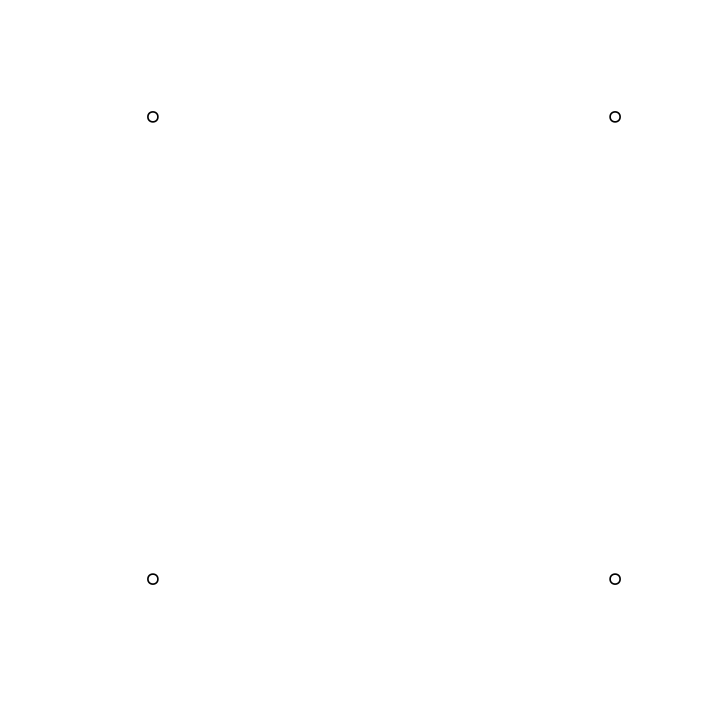

In [8]:
points <- rbind(c(1,1), c(1, 2), c(2, 1), c(2, 2))
points <- st_multipoint(points)
plot(points)

Polygons are built up of linestrings

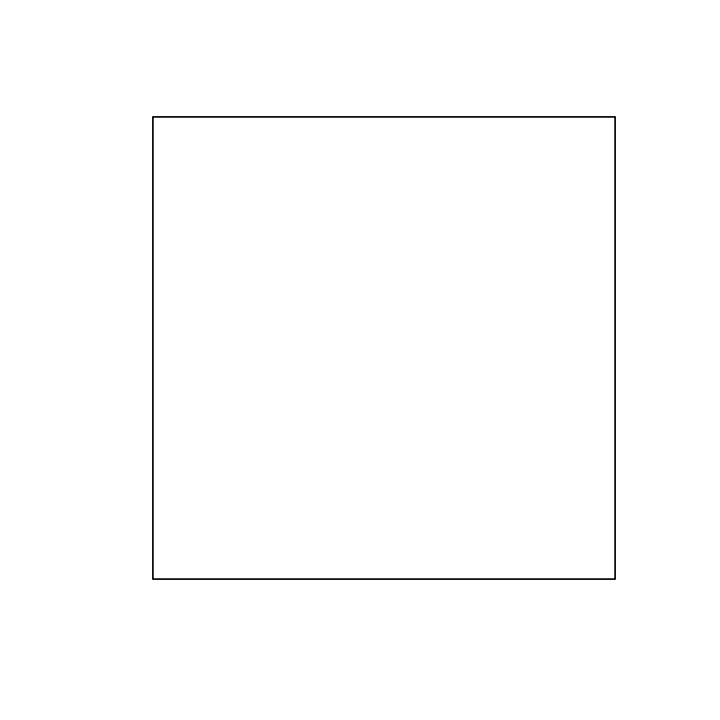

In [9]:
polygon_strings <- rbind(c(1,1), c(1, 2), c(2, 2), c(2, 1), c(1, 1))
polygon_list = list(polygon_strings)
plot(st_polygon(polygon_list))

Multipolygons are collections of polygons. This enable describing multiple distinct separate polygons within the same row of an `sf` object. They would be the right type if, for example, you wanted to plot Japan alongside other countries. Multipolygons can also have holes, whereas polygons cannot. 

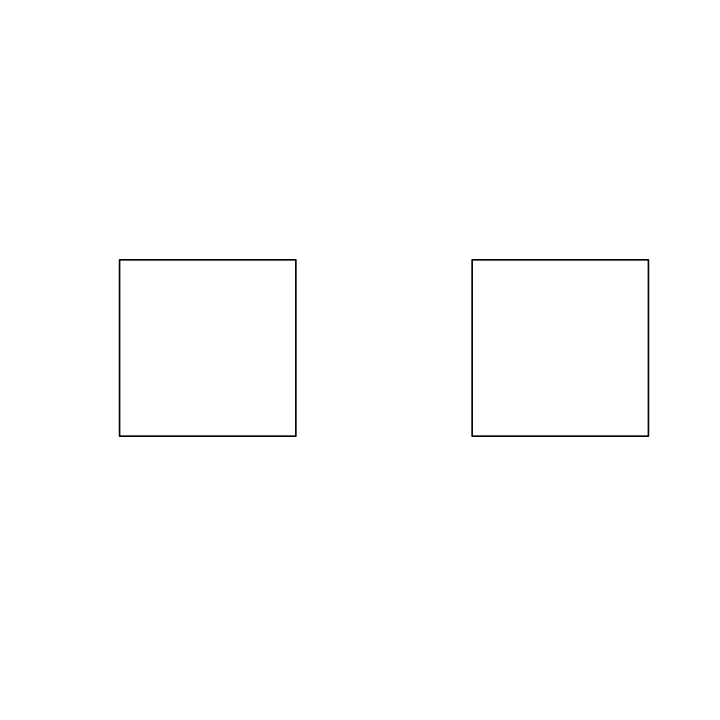

In [10]:
polygon_strings_2 <- rbind(c(3,1), c(3, 2), c(4, 2), c(4, 1), c(3, 1))
multipolygon = st_polygon(list(polygon_strings, polygon_strings_2))
plot(multipolygon)

In general, `R` will take care of defining the geometries for you. Usually you'll know to expect either points or polygons based on the nature of your data. For instance, traffic stops or schools will probably be stored as points, while school districts or election precincts will be polygons.

Also in general, you might find polygons and multipolygons being used interchangeably. In this dataset all the precincts are labelled as multipolygons even though most of them could be polygons. As far as I know, this is fine. Multipolygon accepts a broader range of shapes and won't break if two precincts happen to be separated. 

What exactly are the numbers? These depend on your *coordinate reference system*, which we discuss below.

# Mapz

Here is our data mapped

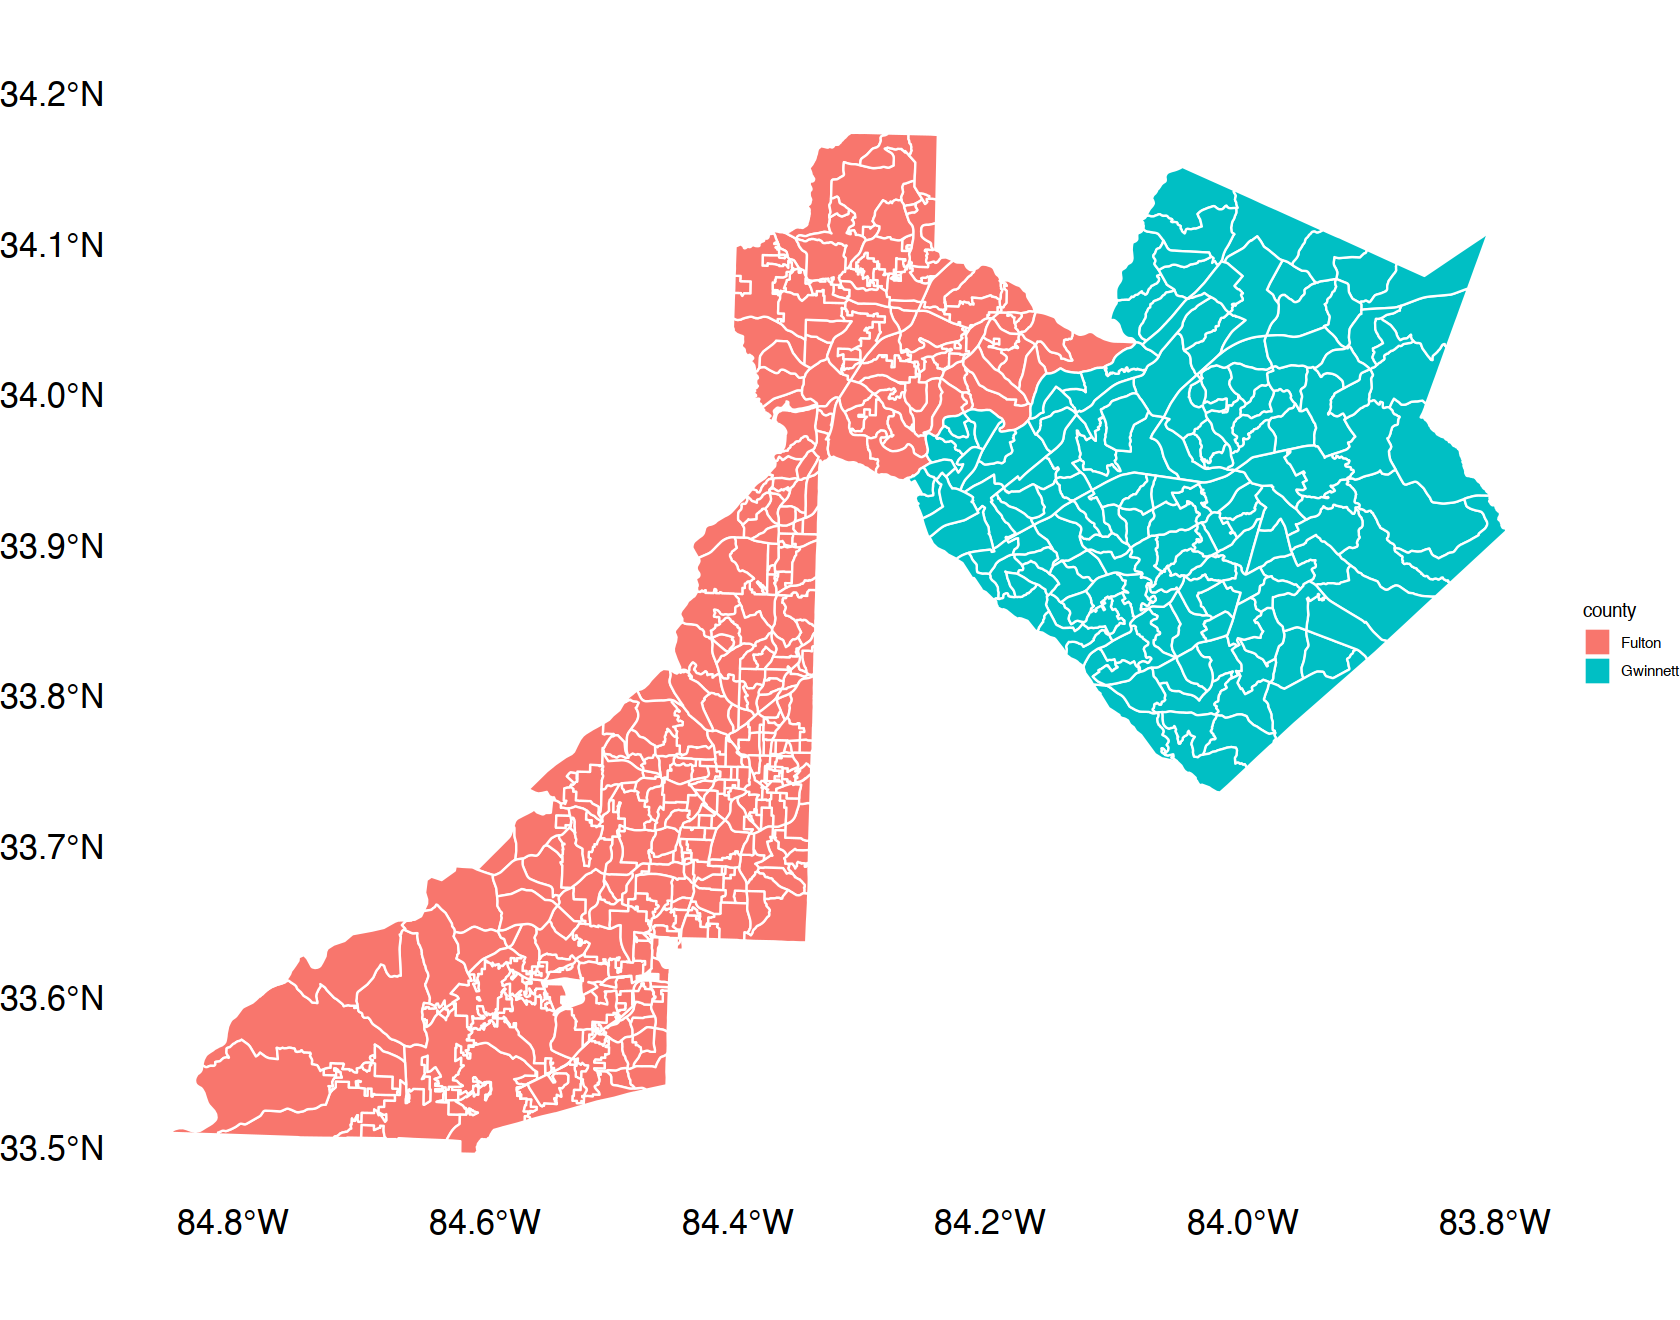

In [11]:
# Switch plot size for mapz
options(repr.plot.width = 14, repr.plot.height = 11)

ggplot(sf_precincts) +
    geom_sf(color = "white", aes(fill = county)) + 
    plot_theme

As you can see, mapping with `sf` and `geom_sf()` is really, really easy. `geom_sf()` behaves much like other plot types. You can set the fills equal to aesthetics easily. Let's see where votes for Stacey Abrams are concentrated...

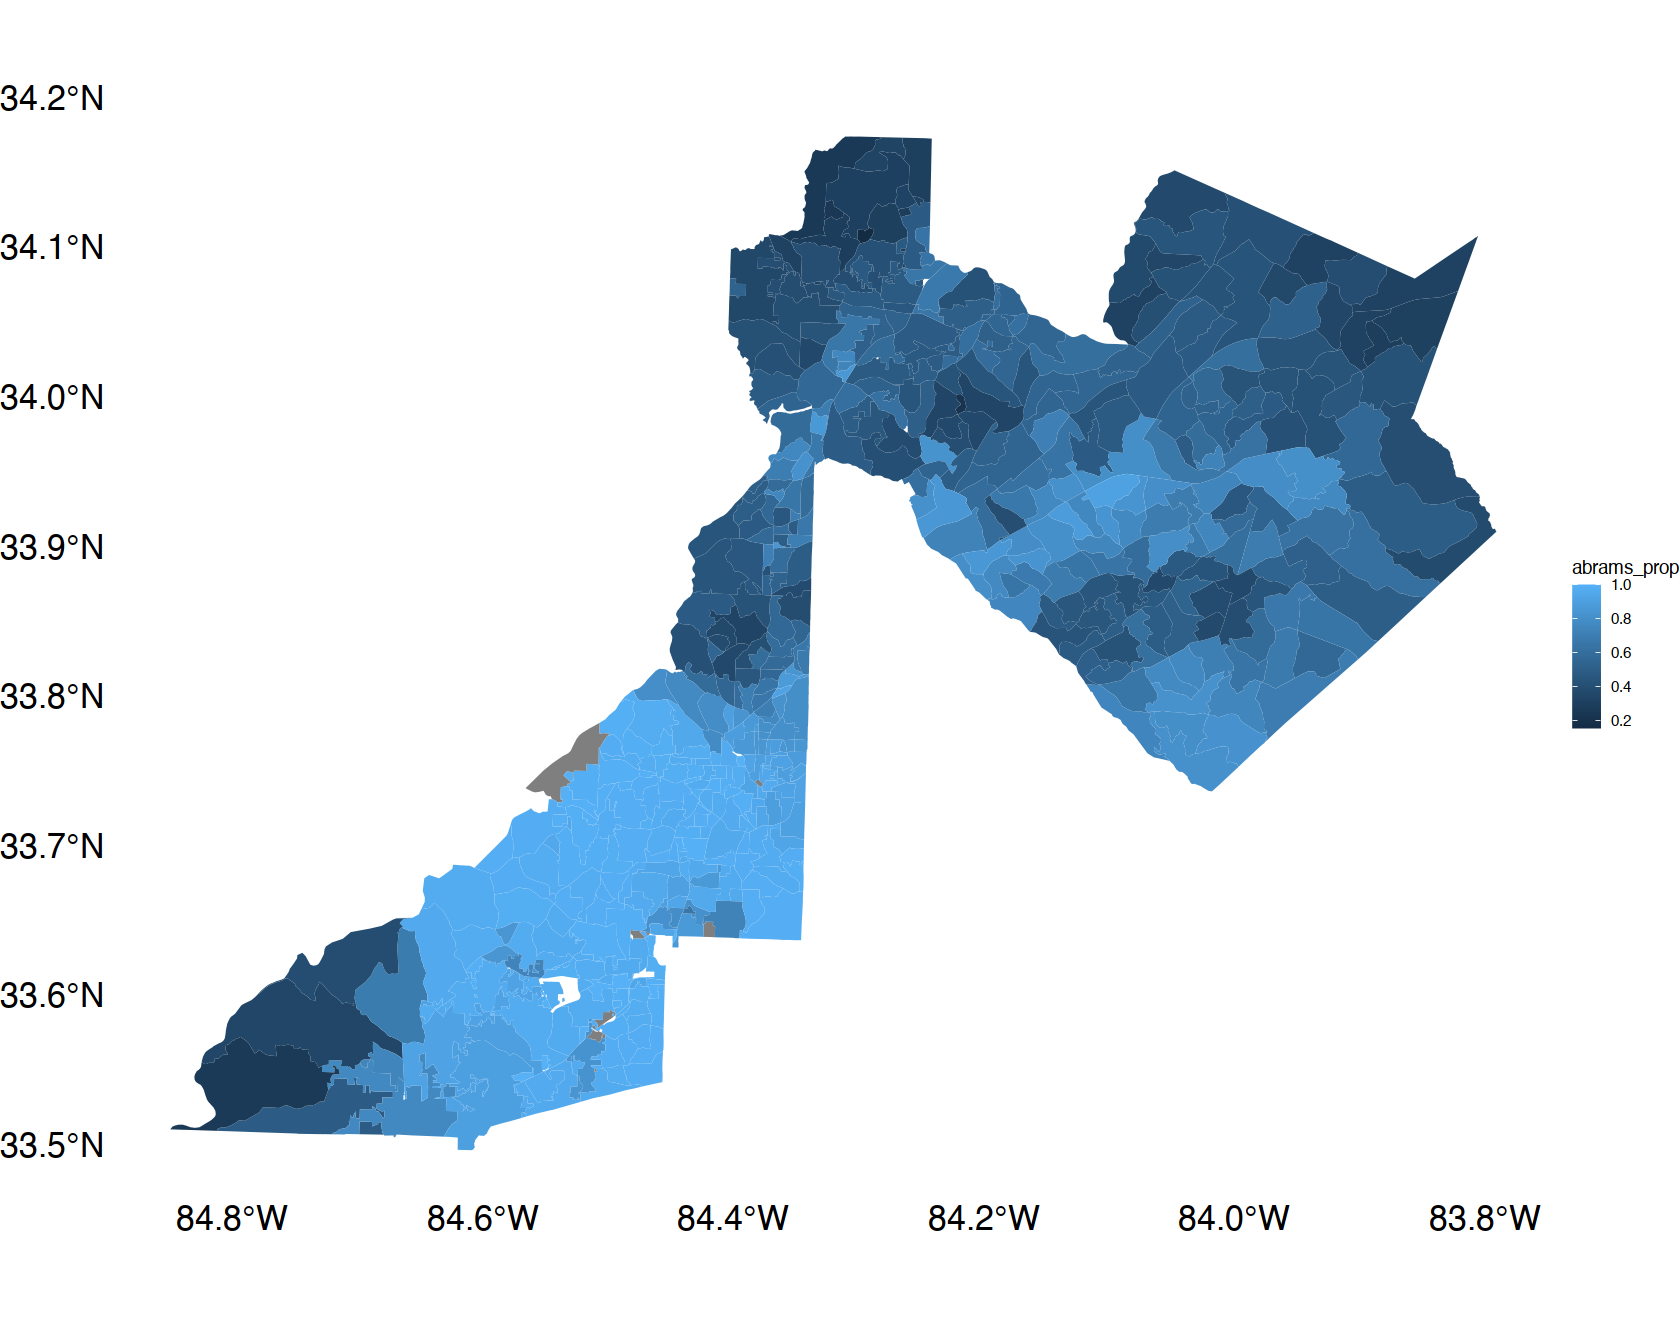

In [12]:
ggplot(sf_precincts) +
    geom_sf(color = "NA", aes(fill = abrams_prop)) + 
    plot_theme

To visualize the borders between the counties, we can take advantage of the fact that `summarize` dissolves geographic areas.

In [13]:
 sf_precincts %>%
    group_by(county) %>%
    summarize()

county   geom                          
1 Fulton   MULTIPOLYGON (((-47827.28 3...
2 Gwinnett POLYGON ((5929.097 438102.8...

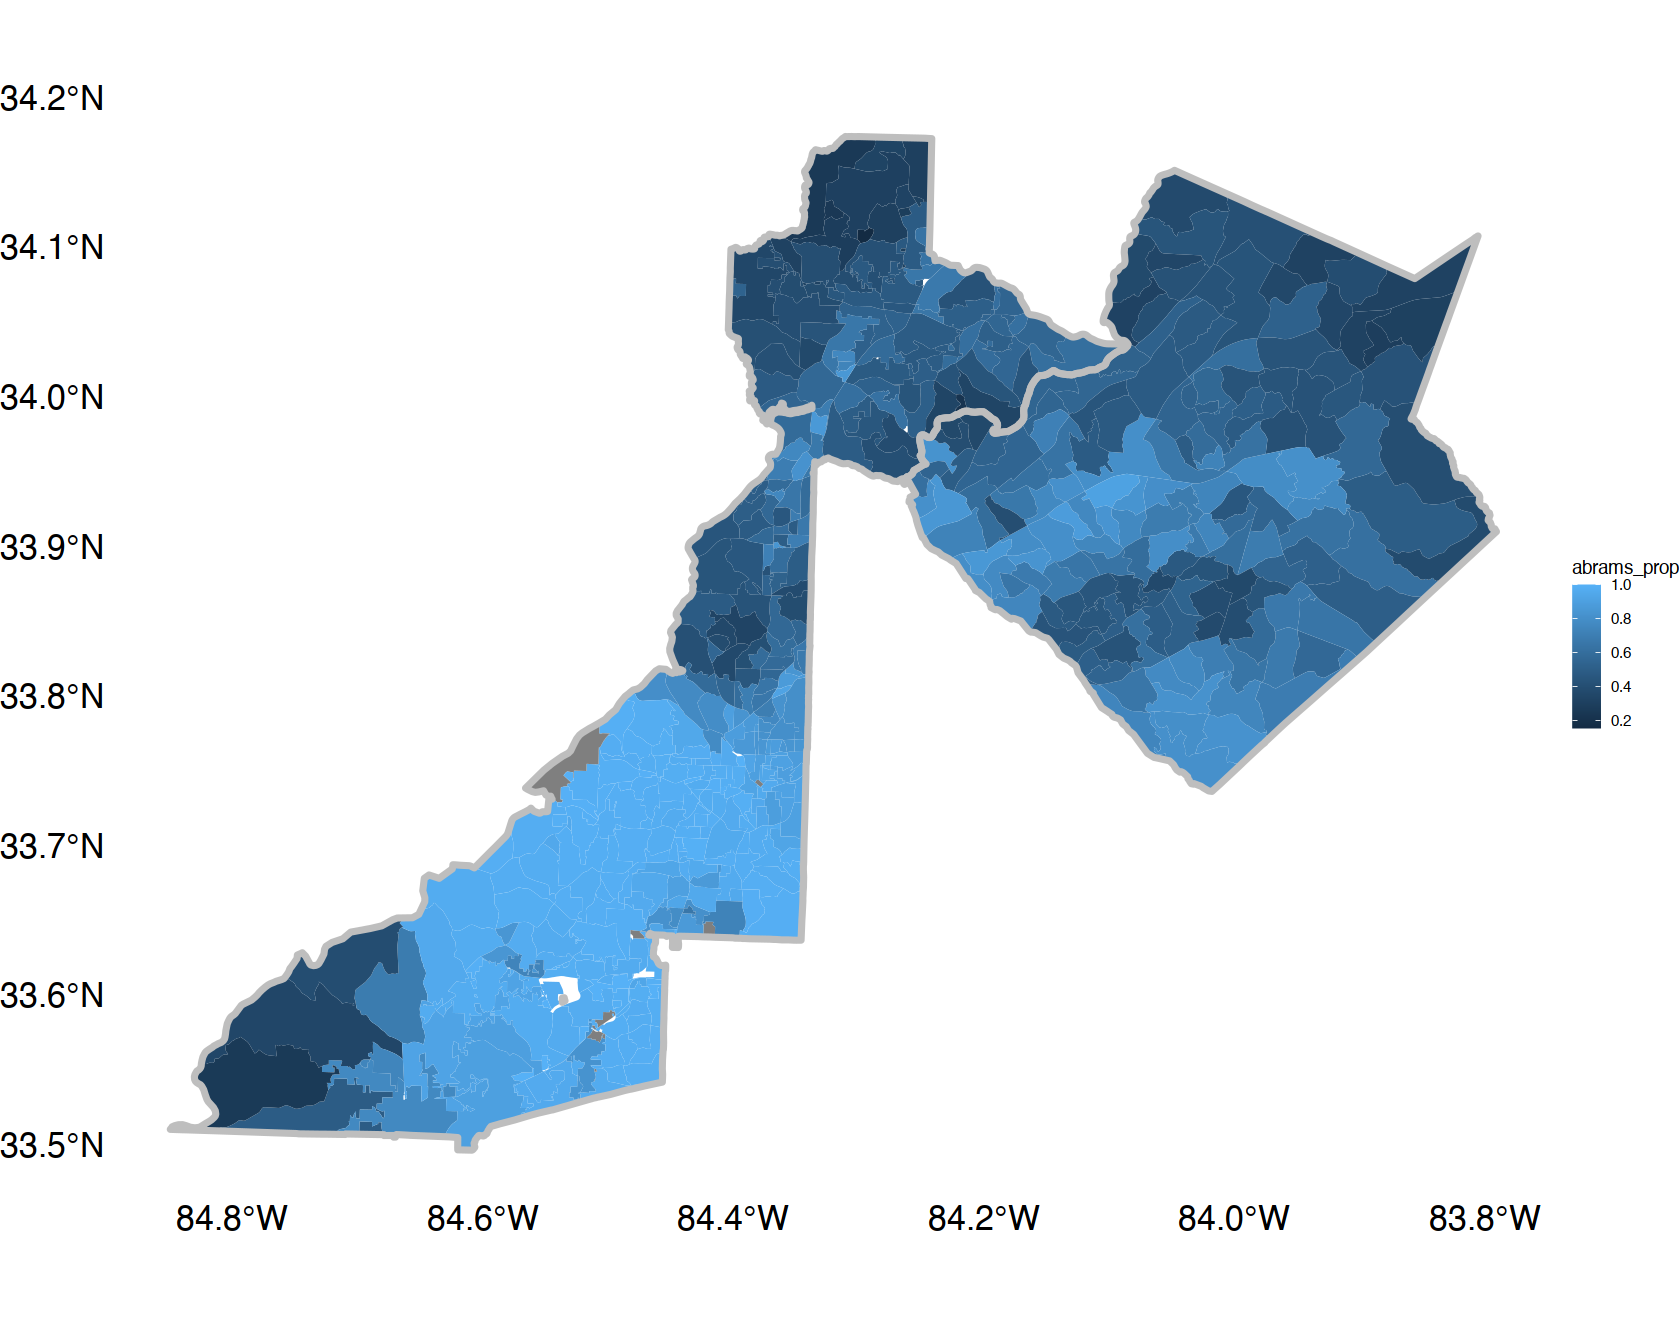

In [14]:
sf_counties <- sf_precincts %>%
    group_by(county) %>%
    summarize() %>%
    sfheaders::sf_remove_holes()
ggplot() +
    geom_sf(data = sf_precincts, color = "NA", aes(fill = abrams_prop)) +
    geom_sf(data = sf_counties, color = 'grey', size = 1.5, fill = "NA") + 
    plot_theme

Where are these counties within Georgia?

In [15]:
# Note that to run this yourself you will need to set up an API key. See here:
# https://walker-data.com/tidycensus/articles/basic-usage.html
sf_georgia <- get_acs(
    geography = "state",
    year = 2018,
    variables = "B00001_001",
    state = "Georgia",
    geometry = TRUE
)
sf_georgia

Getting data from the 2014-2018 5-year ACS




  |======================================================================| 100%


GEOID NAME    variable   estimate geometry                      
1 13    Georgia B00001_001 651000   MULTIPOLYGON (((-81.27939 3...

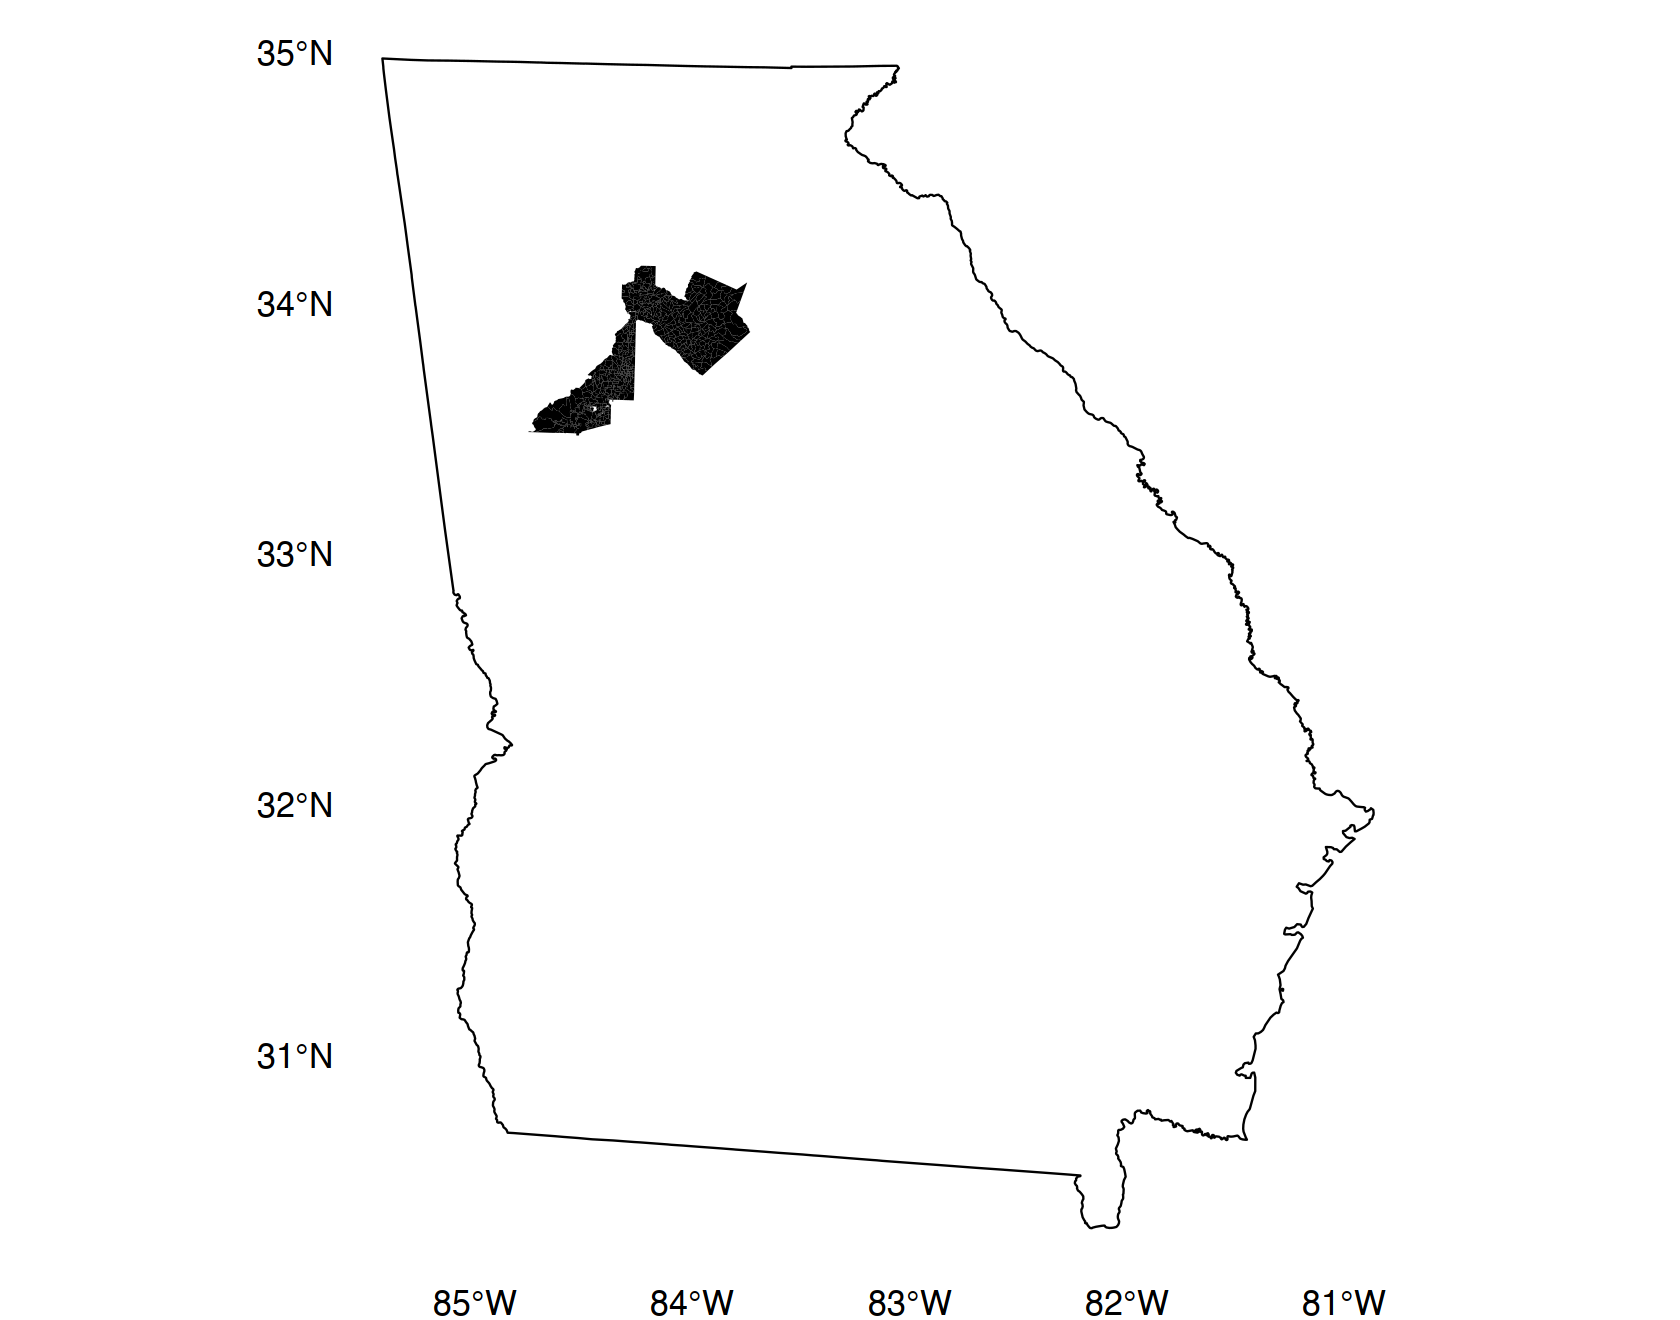

In [16]:
ggplot() +
    geom_sf(data = sf_precincts, color = "NA", fill = "black") + 
    geom_sf(data = sf_georgia, color = "black", fill = "NA") +
    plot_theme

---

# Coordinate Reference Systems (CRS)

TLDR; CRS defines the units for your points.

The two-dimensional planes upon which the above maps are plotted makes the units of maps seem straightforward, when in reality they are not. We have known for some time that the earth is not a flat two-dimensional plane. It is round, more of an ellispoid than a sphere, and covered with peaks and valleys. 

CRS's are different measurement systems that have different strengths and weaknesses when it comes to handling the complexity of the Earth's shape. All of them have some risk of being innaccurate, and this *might* matter if you are doing highly precise spatial operations. There are lots of different CRS's you can read about [here](https://geocompr.robinlovelace.net/spatial-class.html#crs-intro).

`sf` objects typically come with a preassigned CRS:

In [17]:
st_crs(sf_precincts)

Coordinate Reference System:
  User input: NAD83(2011) / Georgia East 
  wkt:
PROJCRS["NAD83(2011) / Georgia East",
    BASEGEOGCRS["NAD83(2011)",
        DATUM["NAD83 (National Spatial Reference System 2011)",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",6318]],
    CONVERSION["SPCS83 Georgia East zone (meters)",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",30,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-82.1666666666667,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9999,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",200000,
            LENG

This is a CRS I found on the Google. I don't understand most of this description. I do know this is part of the NAD83 CRS. NAD83 is one of the two most popular CRS's. The other is WGS84. WGS84 is what's called a *geocentric datum*, meaning it's center is the center of the Earth and it is agnostic to abnormalities on surface of the Earth. In contrast, NAD83 is a *geocentric datum*, meaning it is optimized differently for use in different regions. I picked one that is optimized for use in Georgia.

This CRS was set by running `st_transform(sf_precincts, 6444)`. `6444` is its `epsg` code. `epsg` codes are the easy way to CRSs in R. The other is to write a `proj4string`, which involves writing out the specifics of the CRS in detail. I've never done this and don't know how to do this.

## Projected CRS

Projected CRS projects geographic space onto a two dimensional plane. This introduces some degree of distortion while enabling more flexibility in analysis.

## Takeaways

CRS and projections are a very complicated topic and there's a lot of options available. I think it's easy to get bogged down in this. Probably the best approach is to find a CRS/projection combination that works well for your data and be consistent about applying it. As long as you do this, the remainder of your workflow *should* go smoothly. You can see a list of the available `epsg` codes using `rgdal::make_EPSG()`

In [18]:
crs_data <- rgdal::make_EPSG()
head(crs_data)

code note   prj4                                                   prj_method
1 3819 HD1909 +proj=longlat +ellps=bessel +no_defs +type=crs         (null)    
2 3821 TWD67  +proj=longlat +ellps=aust_SA +no_defs +type=crs        (null)    
3 3822 TWD97  +proj=geocent +ellps=GRS80 +units=m +no_defs +type=crs (null)    
4 3823 TWD97  +proj=longlat +ellps=GRS80 +no_defs +type=crs          (null)    
5 3824 TWD97  +proj=longlat +ellps=GRS80 +no_defs +type=crs          (null)    
6 3887 IGRS   +proj=geocent +ellps=GRS80 +units=m +no_defs +type=crs (null)

In [19]:
crs_data %>% 
    filter(code == 6444)

code note                      
1 6444 NAD83(2011) / Georgia East
  prj4                                                                                                                
1 +proj=tmerc +lat_0=30 +lon_0=-82.1666666666667 +k=0.9999 +x_0=200000 +y_0=0 +ellps=GRS80 +units=m +no_defs +type=crs
  prj_method         
1 Transverse Mercator

# Spatial Operations

For most of this section we'll use a silly dataset I found [here](https://hifld-geoplatform.opendata.arcgis.com/datasets/major-sport-venues?geometry=80.704%2C9.698%2C55.567%2C57.839) that contains the point locations of sports stadiums throughout the US. I've filtered it down to just the stadiums in Georgia.

In [20]:
sf_sports <- read_sf("data/sports_venues.gpkg")
head(sf_sports)

OBJECTID VENUEID NAME                         ADDRESS                       
1  72       99     BOBBY DODD STADIUM           155 NORTH AVENUE NW           
2  73      100     SANFORD STADIUM              SANFORD DRIVE AND FIELD STREET
3 204      240     GEORGIA STATE STADIUM        755 HANK AARON DRIVE          
4 239      276     EAST LAKE GOLF CLUB          2575 ALSTON DRIVE SOUTHEAST   
5 240      277     AUGUSTA NATIONAL GOLF COURSE 807 EISENHOWER DRIVE          
6 241      278     SEA ISLAND GOLF CLUB         100 RETREAT ROAD              
  CITY             STATE ZIP   ZIP4          TELEPHONE      TYPE       ⋯
1 ATLANTA          GA    30332 NOT AVAILABLE (404) 894-2000 SINGLE USE ⋯
2 ATHENS           GA    30605 NOT AVAILABLE (706) 542-9036 SINGLE USE ⋯
3 ATLANTA          GA    30315 NOT AVAILABLE (404) 413-4020 SINGLE USE ⋯
4 ATLANTA          GA    30317 NOT AVAILABLE (404) 373-5722 SINGLE USE ⋯
5 AUGUSTA          GA    30904 NOT AVAILABLE (706) 737-4067 SINGLE USE ⋯
6 ST SIMONS ISLAND GA    31522 NOT AVAILABLE (800) 732-4752 SINGLE USE ⋯
  NAICS_DESC                                                              
1 PROMOTERS OF PERFORMING ARTS, SPORTS, AND SIMILAR EVENTS WITH FACILITIES
2 PROMOTERS OF PERFORMING ARTS, SPORTS, AND SIMILAR EVENTS WITH FACILITIES
3 PROMOTERS OF PERFORMING ARTS, SPORTS, AND SIMILAR EVENTS WITH FACILITIES
4 GOLF COURSES AND COUNTRY CLUBS                                          
5 GOLF COURSES AND COUNTRY CLUBS                                          
6 GOLF COURSES AND COUNTRY CLUBS                                          
  SOURCE                                                              
1 http://ramblinwreck.com/sports/genrel/facilities/bobby-dodd-stadium/
2 https://georgiadogs.com/sports/2017/6/16/sanford-stadium.aspx       
3 https://stadium.gsu.edu/                                            
4 https://www.eastlakegolfclub.com/                                   
5 http://www.masters.com/en_US/index.html                             
6 https://www.seaisland.com/golf/                                     
  SOURCEDATE VAL_METHOD    VAL_DATE   NAME2         NAME3         FORMERNM     
1 2015-01-30 IMAGERY/OTHER 2018-08-14 NOT AVAILABLE NOT AVAILABLE NOT AVAILABLE
2 2015-01-30 IMAGERY/OTHER 2018-08-14 NOT AVAILABLE NOT AVAILABLE NOT AVAILABLE
3 2015-01-30 IMAGERY/OTHER 2018-08-30 NOT AVAILABLE NOT AVAILABLE TURNER FIELD 
4 2015-01-30 IMAGERY/OTHER 2018-08-31 NOT AVAILABLE NOT AVAILABLE NOT AVAILABLE
5 2015-01-30 IMAGERY/OTHER 2018-08-31 NOT AVAILABLE NOT AVAILABLE NOT AVAILABLE
6 2015-01-30 IMAGERY/OTHER 2018-08-31 NOT AVAILABLE NOT AVAILABLE NOT AVAILABLE
  YEARCHNG      geom                    
1 NOT AVAILABLE POINT (-9394569 3998295)
2 NOT AVAILABLE POINT (-9281083 4022064)
3 2016          POINT (-9394191 3993344)
4 NOT AVAILABLE POINT (-9384535 3994410)
5 NOT AVAILABLE POINT (-9130387 3962250)
6 NOT AVAILABLE POINT (-9062026 3650717)

If we want to use this `sf` object together with our election precincts one, we first need to line up their CRS.

In [21]:
sf_sports <- st_transform(sf_sports, st_crs(sf_precincts))
st_crs(sf_sports) == st_crs(sf_precincts)

[1] TRUE

Where are these sports stadiums?

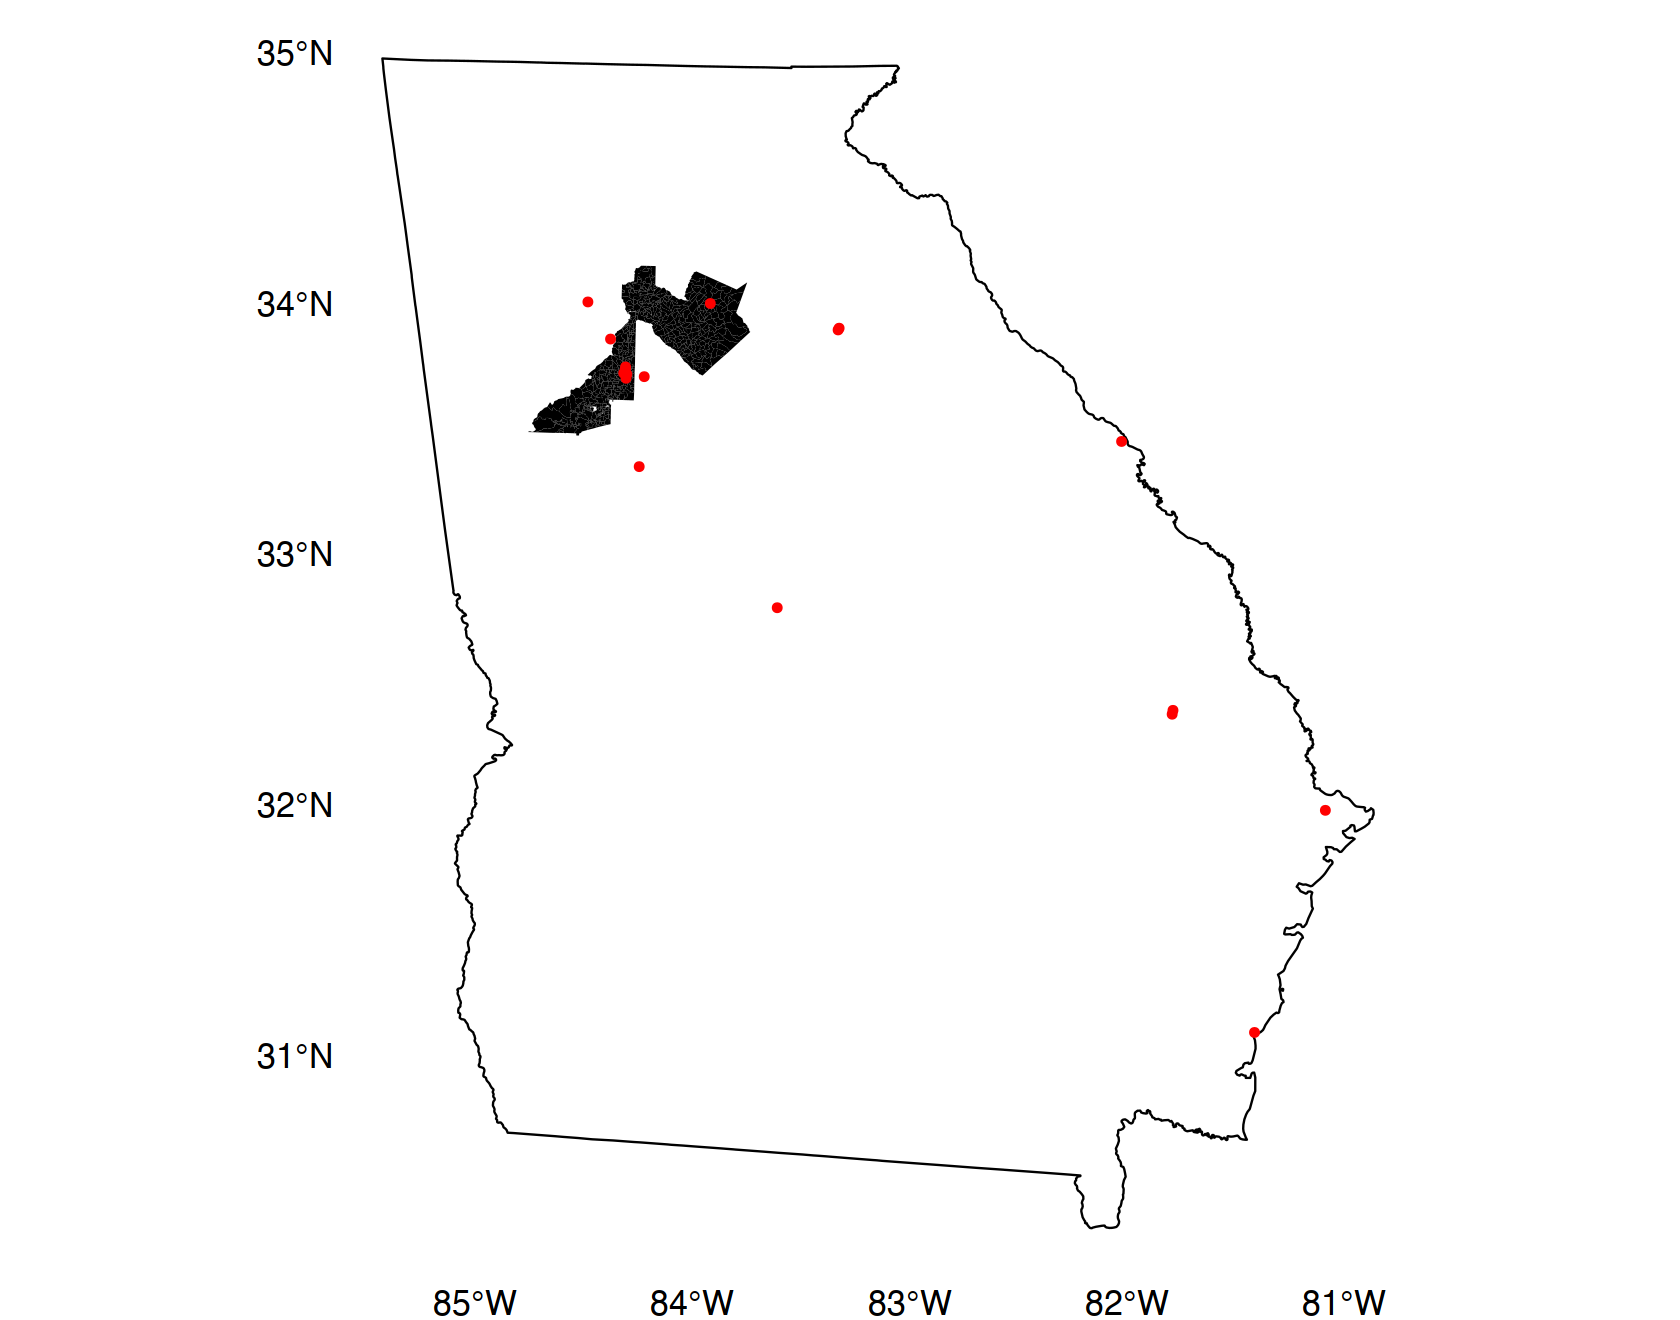

In [22]:
sf_georgia <- st_transform(sf_georgia, st_crs(sf_precincts))

ggplot() +
    geom_sf(data = sf_precincts, color = "NA", fill = "black") + 
    geom_sf(data = sf_georgia, color = "black", fill = "NA") +
    geom_sf(data = sf_sports, color = "red", size = 2) +
    plot_theme

### Filtering

We can get rid of the ones not inside the counties we care about using a filter.

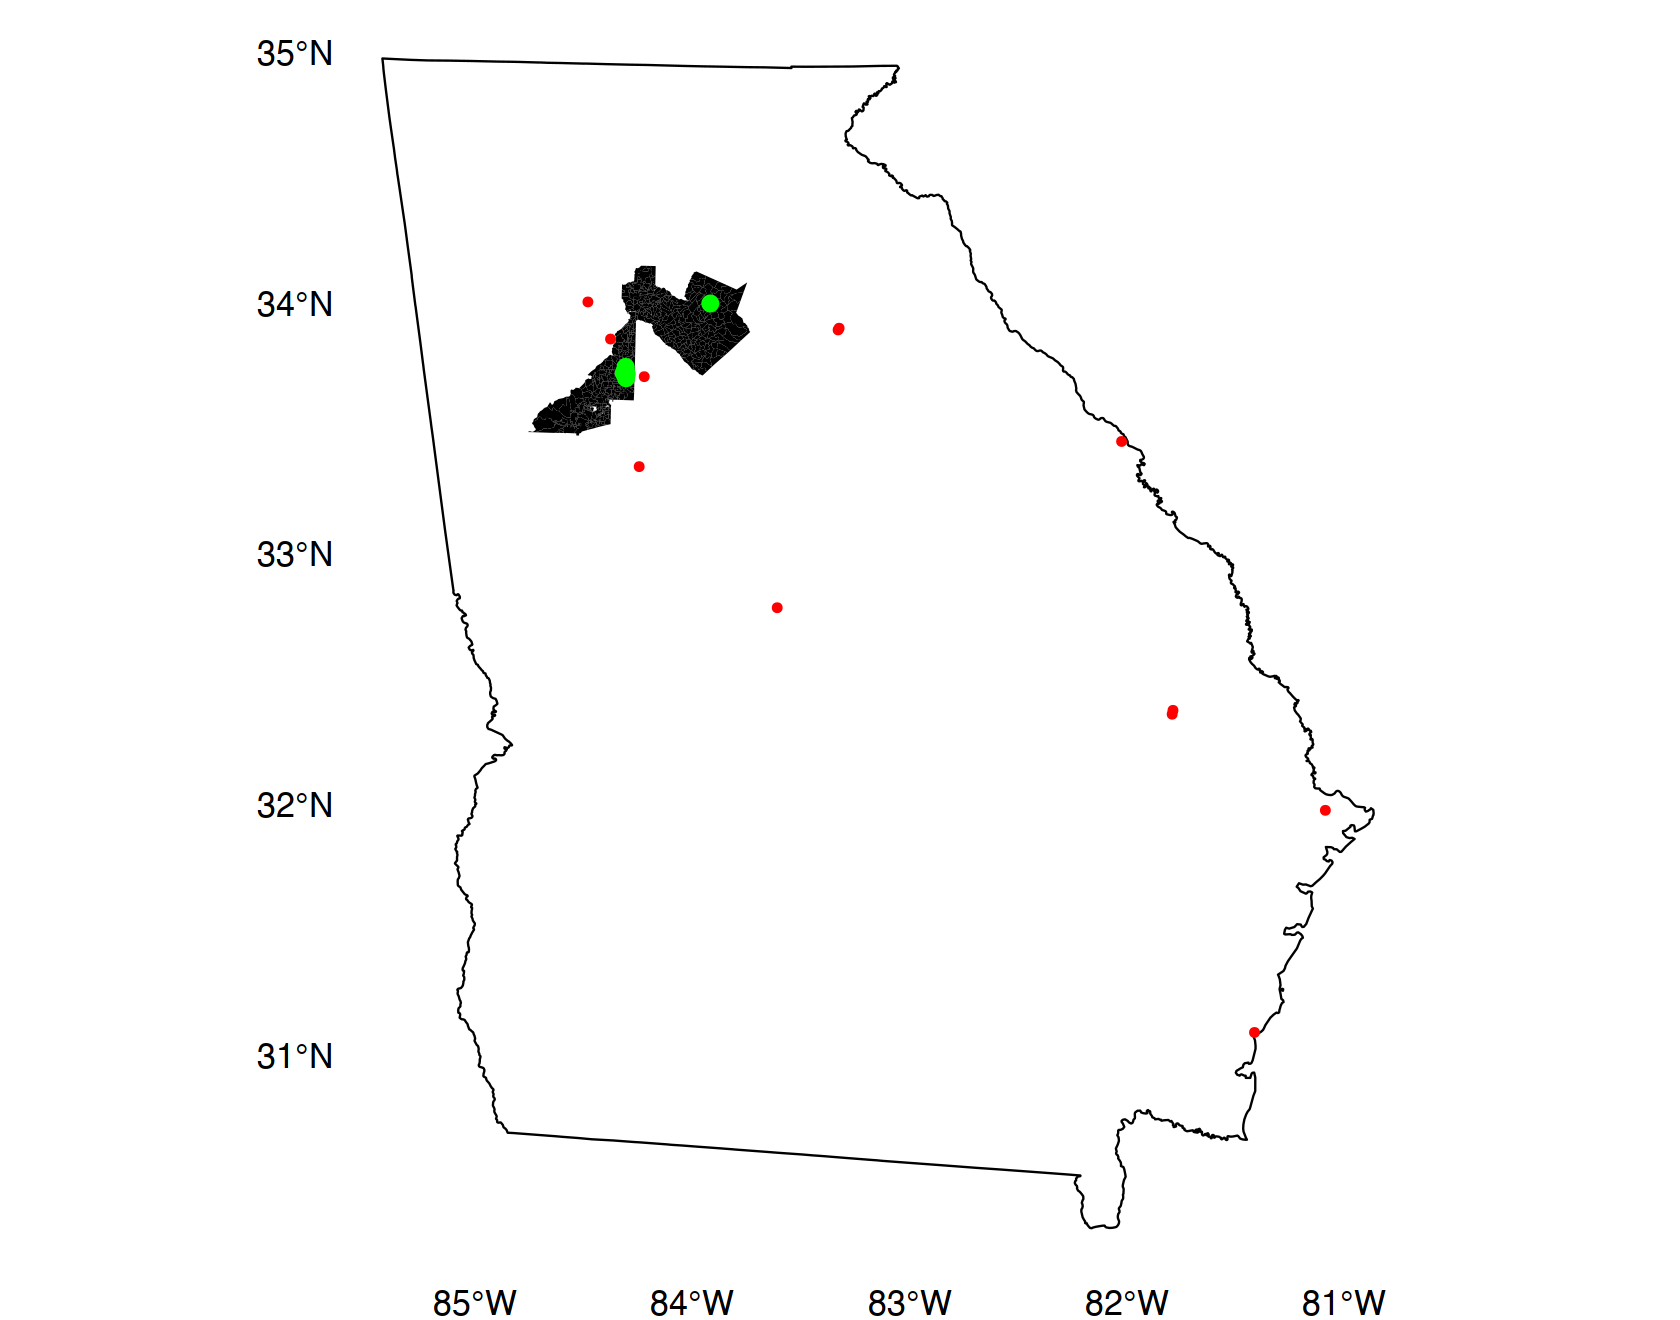

In [23]:
sf_sports_gf <- st_filter(sf_sports, sf_precincts)
ggplot() +
    geom_sf(data = sf_precincts, color = "NA", fill = "black") + 
    geom_sf(data = sf_georgia, color = "black", fill = "NA") +
    geom_sf(data = sf_sports, color = "red", size = 2) +
    geom_sf(data = sf_sports_gf, color = "green", size = 4) +
    plot_theme

### Joining points to polygons

At this point it's still going to be hard to do any analysis, because the information we're interested in is split across two objects. The sports stadiums are in `sf_sports`, and the precincts are in `sf_precincts`. If we want to analyse the effect of having a sports stadium on a precincts' election results (we don't, but like if we pretend we do), we need to get a variable in the `sf_precincts` object that says whether or not a precinct contains a sports stadium.

For this we do a spatial join

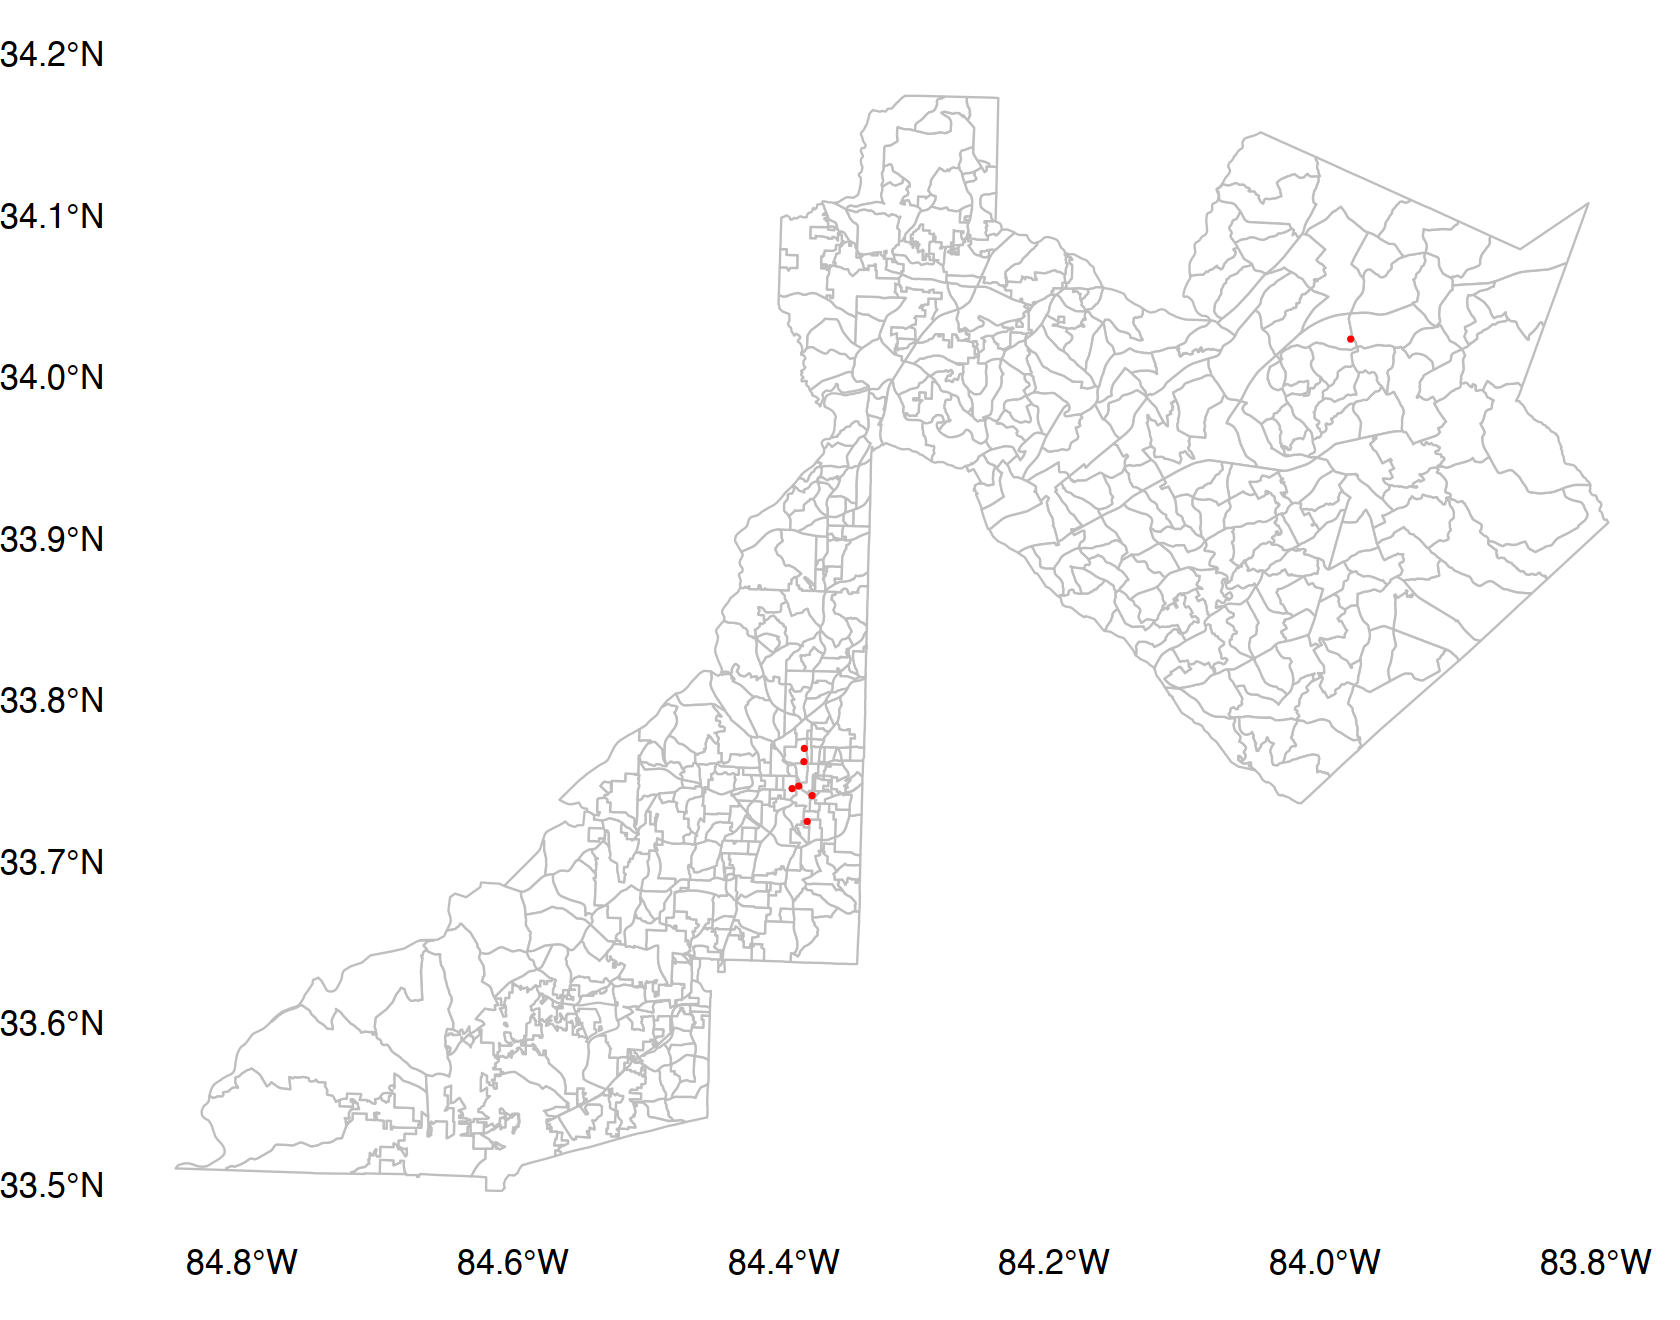

In [24]:
ggplot() +
    geom_sf(data = sf_precincts, color = "grey", fill = "white") + 
    geom_sf(data = sf_sports_gf, color = "red", size = 1) +
    plot_theme

In [25]:
sf_precincts$n_stadiums <- lengths(st_intersects(sf_precincts, sf_sports_gf))

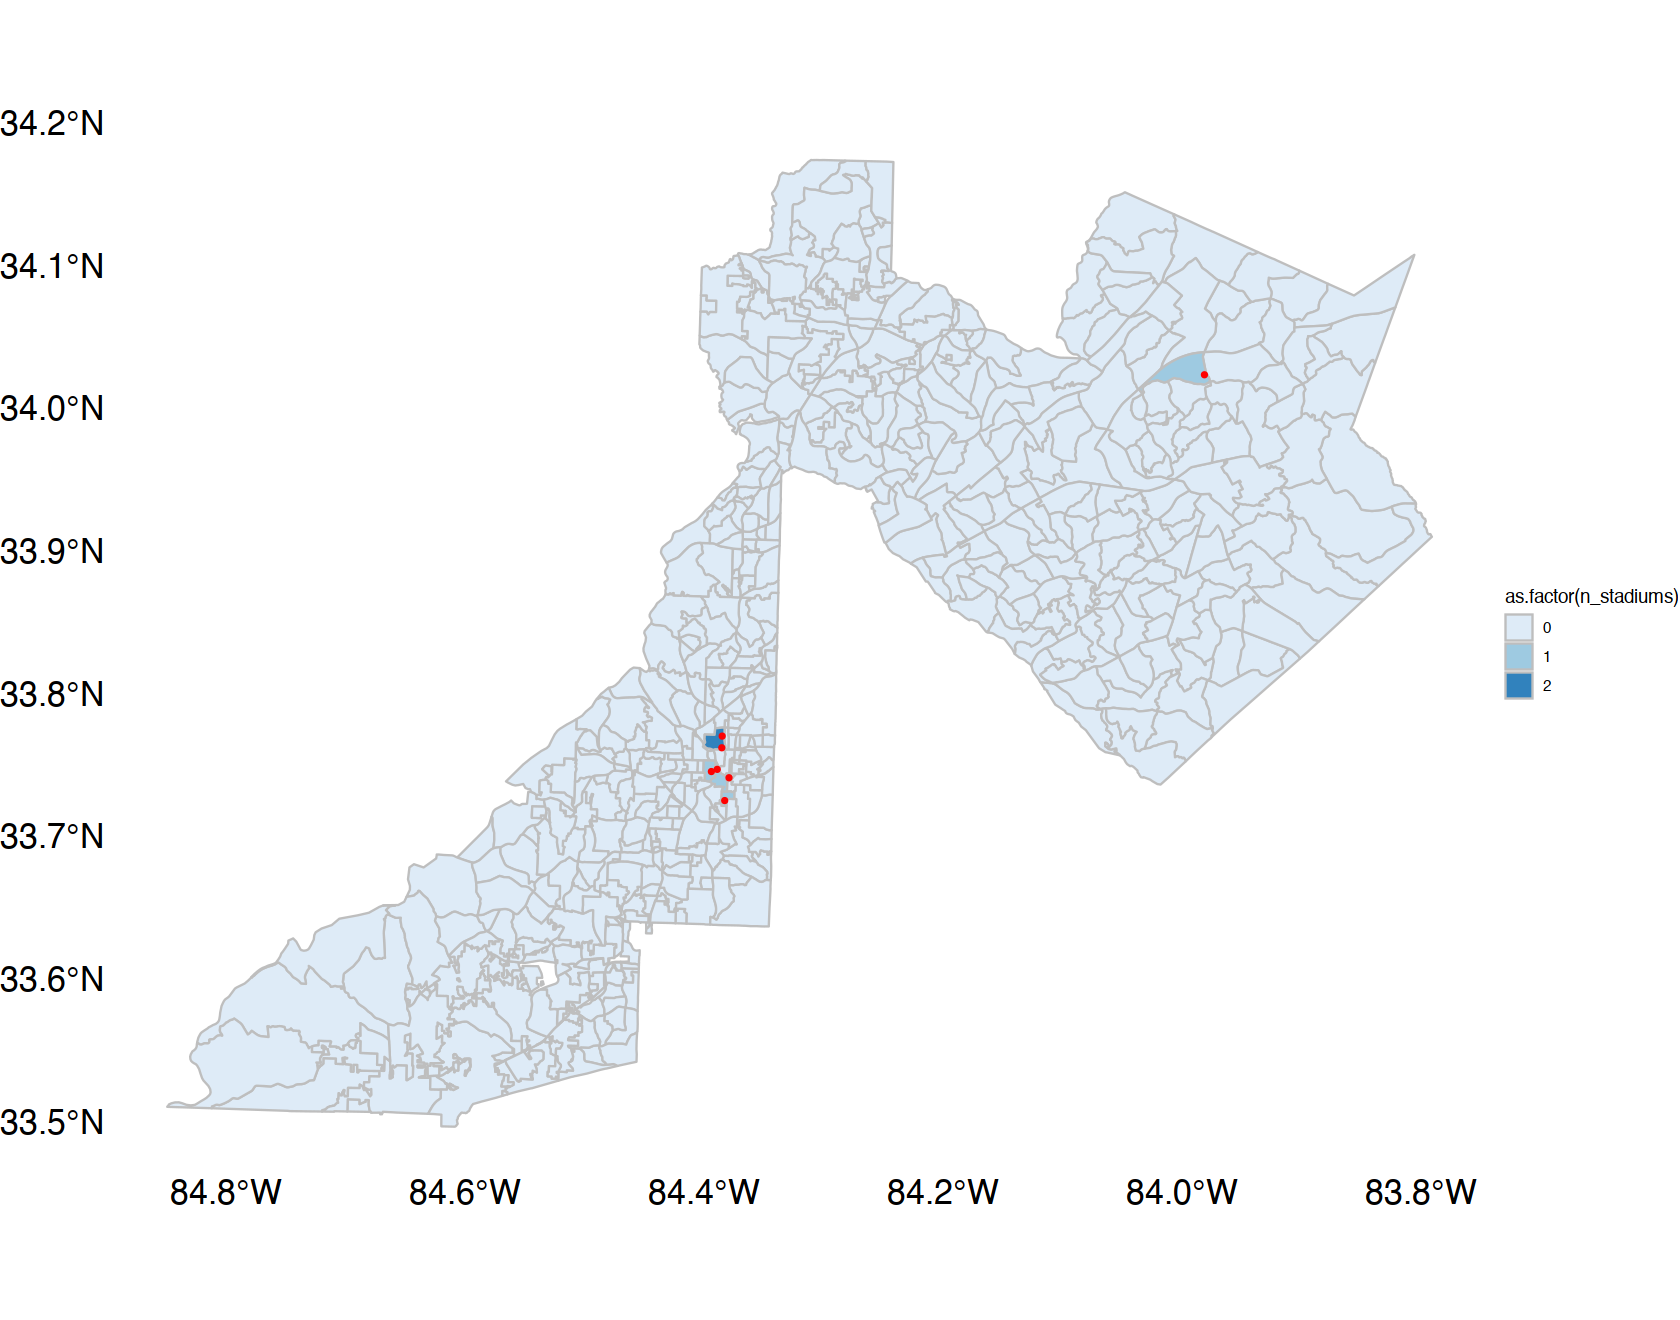

In [26]:
ggplot() +
    geom_sf(data = sf_precincts, color = "grey", aes(fill = as.factor(n_stadiums))) + 
    geom_sf(data = sf_sports_gf, color = "red", size = 1) +
    scale_fill_brewer(type = "seq") +
    plot_theme

# Distances

Now let's try computing the distance from each precinct to the nearest stadium. The first problem we face is that we can theoretically choose any point within a polygon from which to compute a distance. 

### Centroids

Typically people use centroids for this. You can think of centroids as points at the middle of the polygon. 

In actuality it's a bit more complicated than that. A the most straightforward centroid location will be computed by drawing a box around the maximum and minimum heights and widths of a polygon, then taking the direct center of the box. However, you can imagine situations where this method ends up picking a centroid that isn't even in the intended polygon, like if the polygon is L-shaped. There are various other formulations that modify the basic computation to avoid this problem, and which one you choose may affect results in some instances. In most datasets, the choice of centroid computation probably matters for some small (but maybe important) subset of the shapes.

#### When computing centroids with `sf`

* Centroids are computed assuming data lie on a 2D plane. This means you should use a projected CRS when you're computing these.
* `st_centroid()` computes the centroid as described above.
* `st_point_on_surface()` computes a variation of centroids that ensures an area's centroid is within its boundaries.

Warning message in st_centroid.sf(sf_precincts):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_point_on_surface.sf(sf_precincts):
“st_point_on_surface assumes attributes are constant over geometries of x”


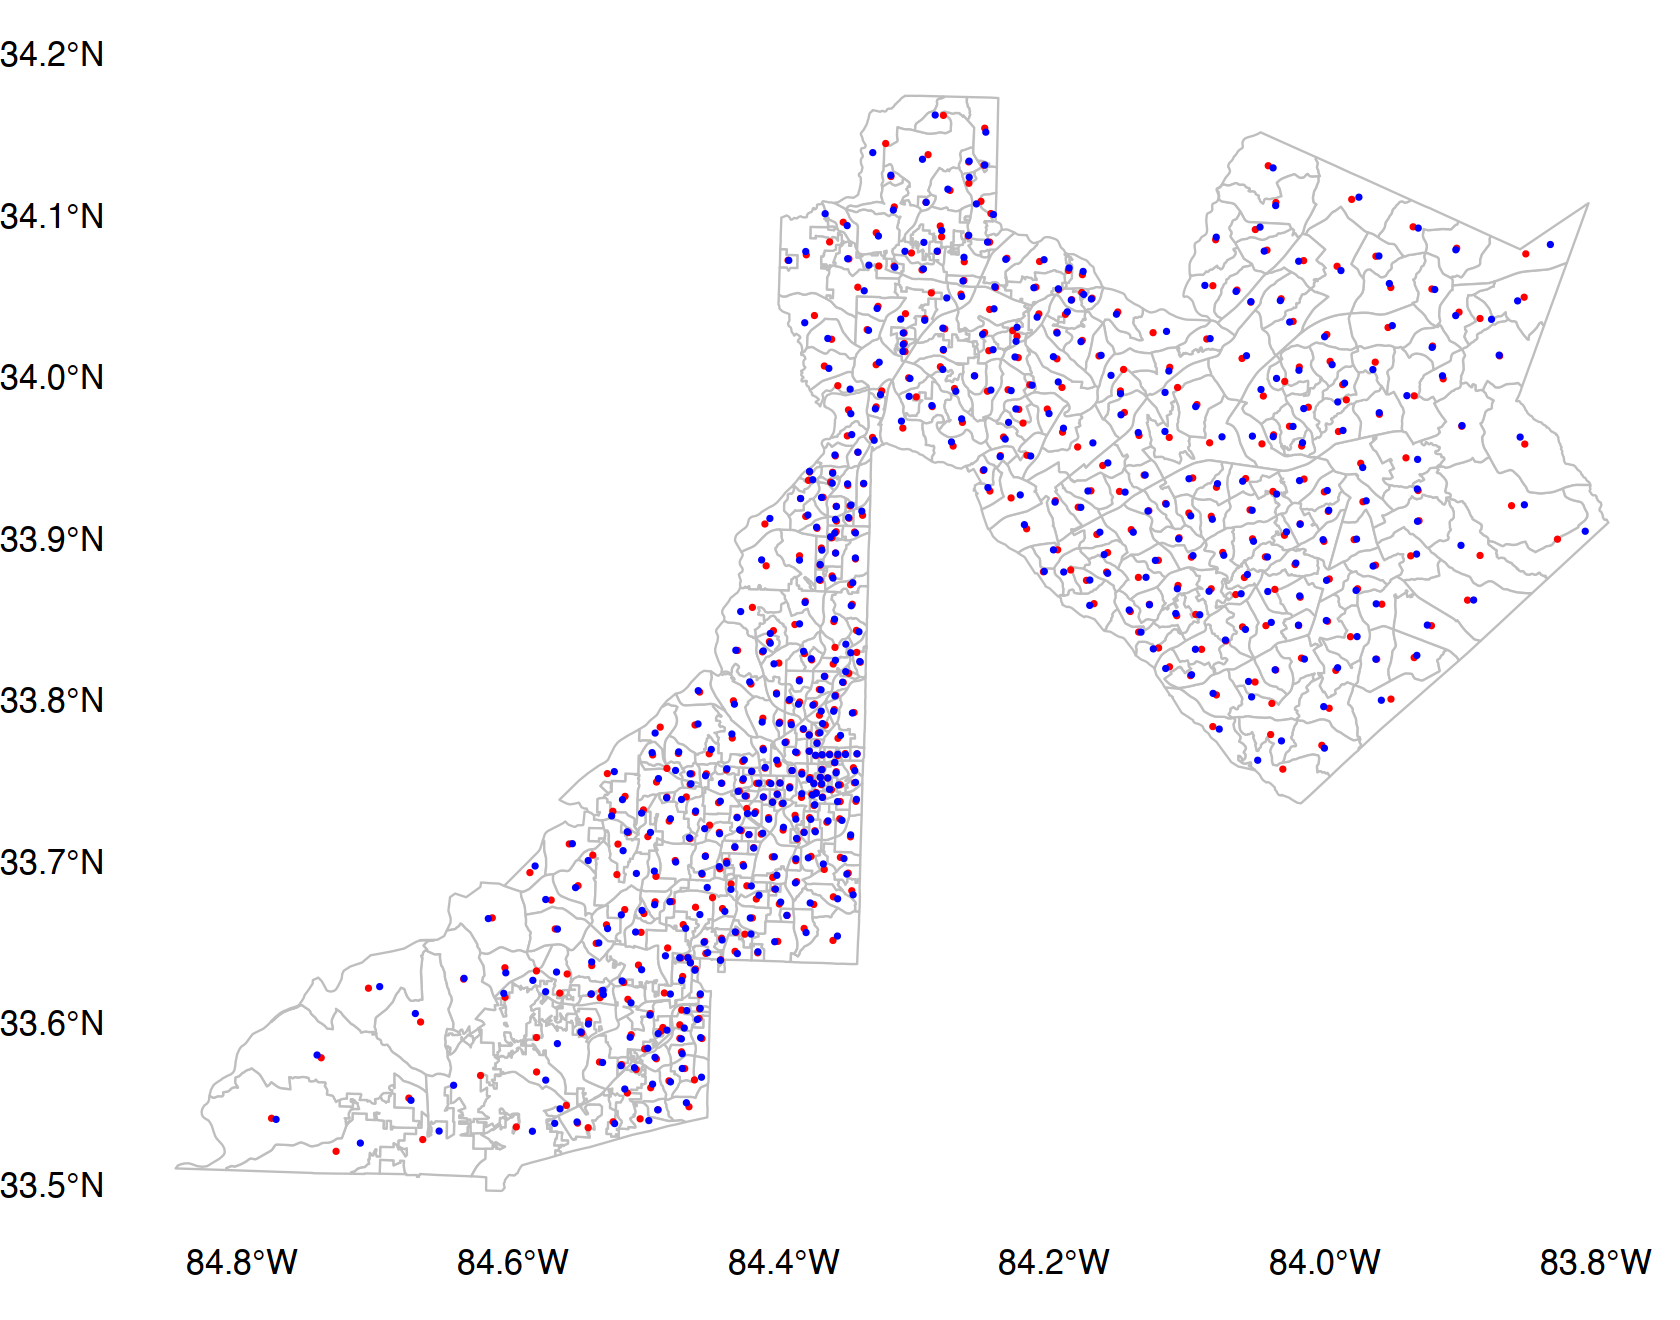

In [27]:
sf_precinct_centroids <- st_centroid(sf_precincts)
sf_precinct_centsonsurface <- st_point_on_surface(sf_precincts)

ggplot() +
    geom_sf(data = sf_precincts, color = "grey", fill = "white") + 
    geom_sf(data = sf_precinct_centroids, color = "red", size = 1) +
    geom_sf(data = sf_precinct_centsonsurface, color = "blue", size = 1) +
    plot_theme

### Getting distance to the nearest stadium

`st_nearest_feature()` takes in to `sf` objects and returns a vector of row indices from the the second object that are closest to each shape in the first.

In [28]:
nearest <- st_nearest_feature(sf_precinct_centroids, sf_sports)
nearest[1:10]

[1]  9 19 18  9  9  3  3 18  9 17

So the first precinct centroid is closest to the stadium in the ninth row of the sports object, and so on. We can do some old-fashioned indexing to get the distances between these points, then add it back to `sf_precincts`

In [29]:
dist_to_nearest <- st_distance(sf_precinct_centroids, sf_sports[nearest,], by_element = TRUE)
sf_precincts$dist_to_nearest <- as.numeric(dist_to_nearest)
head(sf_precincts)

precinct_id_2018 county abrams_prop kemp_prop  metz_prop   total_votes
1 Fulton,08P       Fulton 0.8311688   0.15909091 0.009740260  924       
2 Fulton,Ss09B     Fulton 0.4593047   0.52638037 0.014314928 2445       
3 Fulton,03A       Fulton 0.9811594   0.01449275 0.004347826  690       
4 Fulton,07J       Fulton 0.6469914   0.33352436 0.019484241 1745       
5 Fulton,09E       Fulton 0.9463277   0.04731638 0.006355932 1416       
6 Fulton,12A       Fulton 0.9571585   0.03698279 0.005858660 2731       
  whi_true_total bla_true_total his_true_total asi_true_total oth_true_total
1  457            267           38             18             19            
2 1824             75           27             59             32            
3   29            525            3              1              8            
4 1029            108           23             18             21            
5  159            789           18             16             23            
6  587           1728           36             19             60            
  whi_true   bla_true   his_true    asi_true    oth_true  
1 0.57196496 0.33416771 0.047559449 0.022528160 0.02377972
2 0.90431334 0.03718394 0.013386217 0.029251363 0.01586515
3 0.05123675 0.92756184 0.005300353 0.001766784 0.01413428
4 0.85821518 0.09007506 0.019182652 0.015012510 0.01751460
5 0.15820896 0.78507463 0.017910448 0.015920398 0.02288557
6 0.24156379 0.71111111 0.014814815 0.007818930 0.02469136
  geom                           n_stadiums dist_to_nearest
1 MULTIPOLYGON (((-6803.698 4... 0          2006.889       
2 MULTIPOLYGON (((-5618.893 4... 0          6405.622       
3 MULTIPOLYGON (((-9733.036 4... 0          3442.875       
4 MULTIPOLYGON (((-5155.174 4... 0          4179.650       
5 MULTIPOLYGON (((-10372.33 4... 0          5003.696       
6 MULTIPOLYGON (((-9778.072 4... 0          3418.042

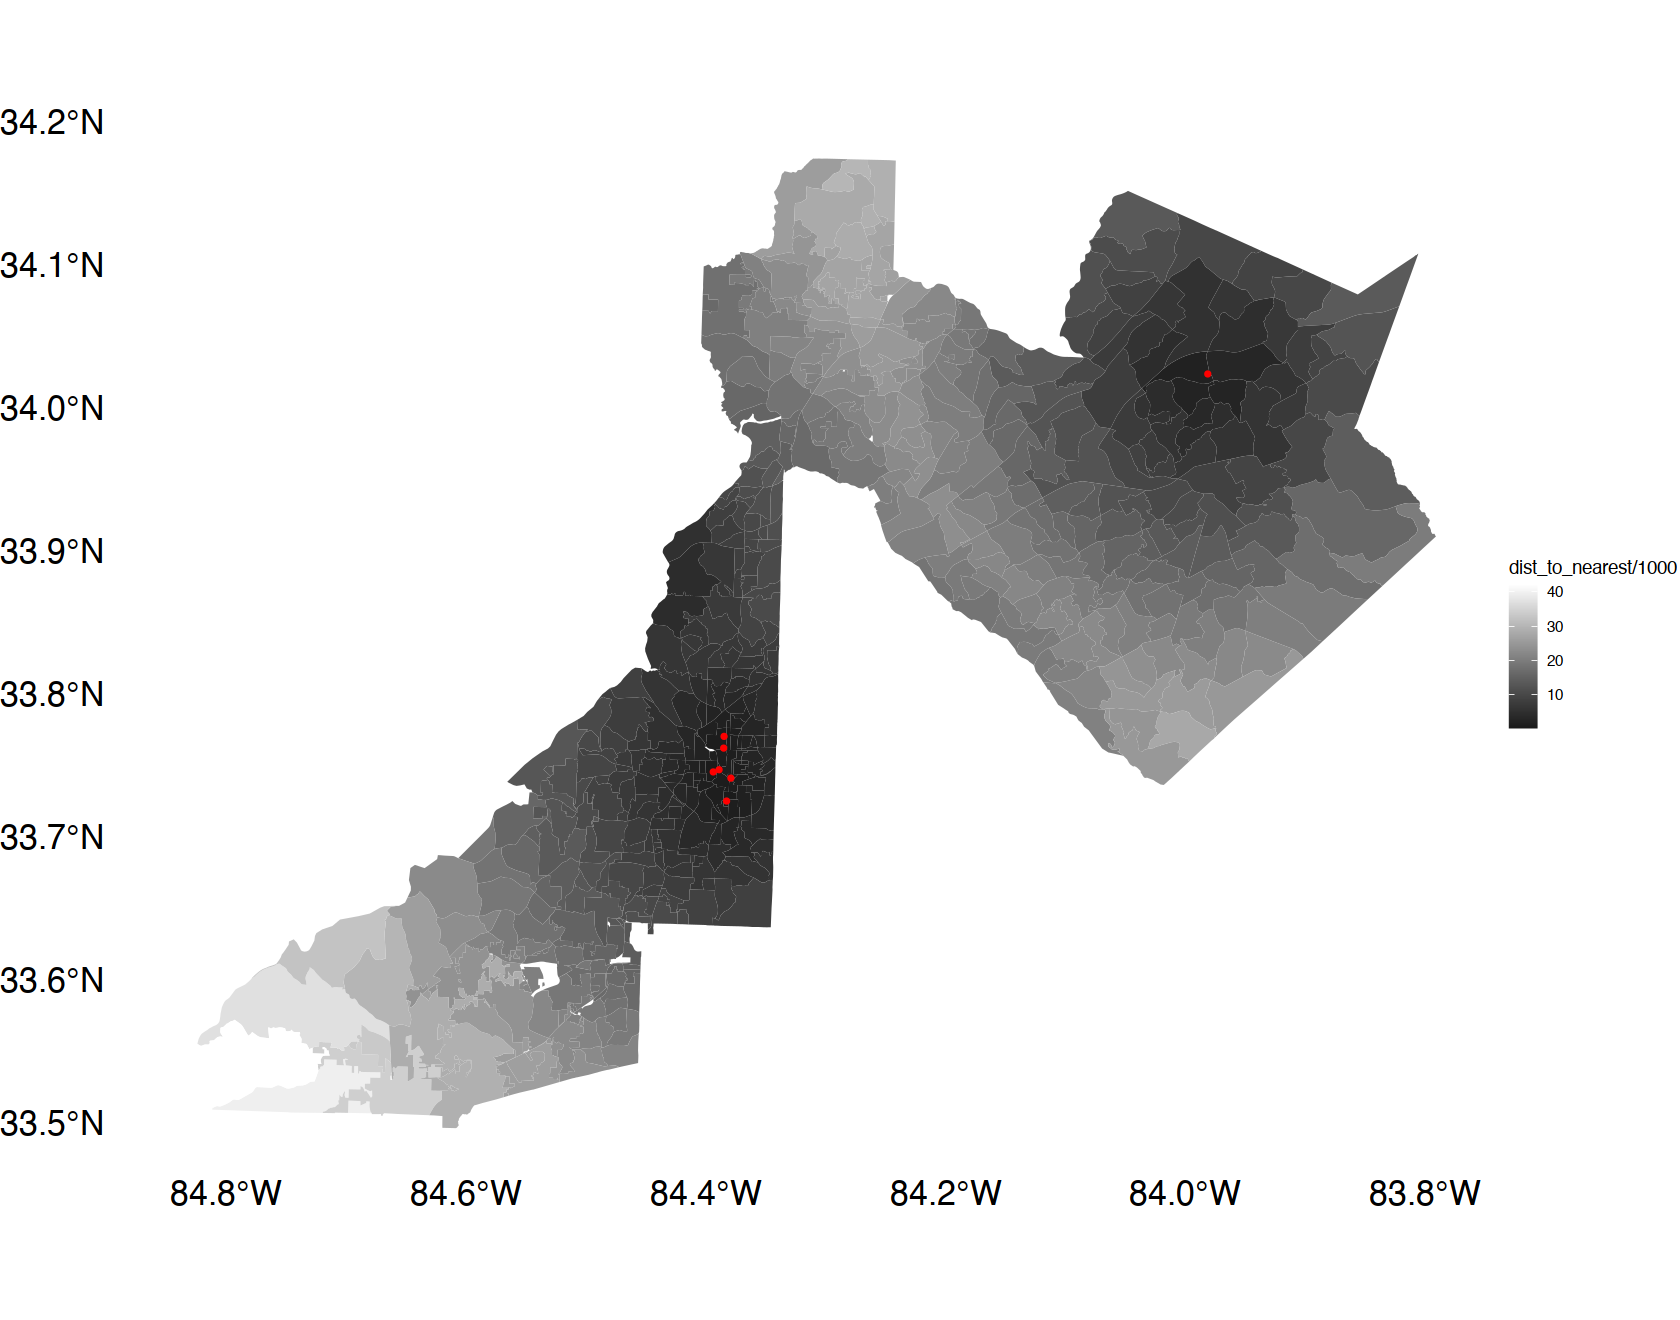

In [30]:
ggplot() +
    geom_sf(data = sf_precincts, color = "NA", aes(fill = dist_to_nearest/1000)) +
    geom_sf(data = sf_sports_gf, color = "red", size = 1) +
    scale_fill_gradient2(low = "black", mid = "grey10", high = "white") +
    plot_theme

# Interpolation

Sometimes you want a measure in one geographic unit, but you only have it in another. For example, in my work I want to know the racial composition of election precincts, but I only know the racial composition of Census blocks. We can use areal-weighted interpolation to crudely transfer the measure from one spatial unit to another.

I say interpolation is crude because it relies on the assumpton that whatever characteristic of an area you're interpolating is spread evenly across the initial geographic surface. This is a very strong assumption that almost never holds. In this case, the populations of different race groups are most certainly *not* spread across census areas. Nonetheless, this tool can be useful when there are no alternatives.

Here we're going to grab data on the voting-aged populations of different race groups at the block-group level and interpolate this over to the election precincts. We could use Census blocks, but it would be slower and speed is important in this tutorial context.

In [31]:
georgia_counties <- c("121", "135")

sf_vap <- purrr::map_dfr(
  georgia_counties,
  ~ tidycensus::get_decennial(
    geography = "block group",
    variables = c(
      "P011002", # total hispanic, 18+
      "P011005", # total white, 18+
      "P011006", # total black, 18+
      "P011008"  # total asian, 18+
    ),
    year = 2010,
    summary_var = "P011001", # total population, 18+,
    state = "GA",
    county = .,
    geometry = TRUE,
    cache = TRUE,
    output = "wide"
  )
)
sf_vap <- sf::st_transform(sf_vap, sf::st_crs(sf_precincts))

Getting data from the 2010 decennial Census


Using Census Summary File 1



  |======================================================================| 100%


Getting data from the 2010 decennial Census


Using Census Summary File 1



In [32]:
head(sf_vap)

GEOID        NAME                                                     
1 131210001001 Block Group 1, Census Tract 1, Fulton County, Georgia    
2 131210002001 Block Group 1, Census Tract 2, Fulton County, Georgia    
3 131210002005 Block Group 5, Census Tract 2, Fulton County, Georgia    
4 131210006001 Block Group 1, Census Tract 6, Fulton County, Georgia    
5 131210010011 Block Group 1, Census Tract 10.01, Fulton County, Georgia
6 131210011001 Block Group 1, Census Tract 11, Fulton County, Georgia   
  P011002 P011005 P011006 P011008 summary_value geometry                      
1  13      578       8      11     617          MULTIPOLYGON (((-2697.423 4...
2  43      779     100      30     969          MULTIPOLYGON (((-3772.528 4...
3  30      653      25      23     745          MULTIPOLYGON (((-4130.731 4...
4 243     2289    1170    1113    4970          MULTIPOLYGON (((-6806.538 4...
5  65      519      85     741    1471          MULTIPOLYGON (((-6773.215 4...
6  57      784     114      72    1052          MULTIPOLYGON (((-5710.451 4...

Here we run the interpolation. There is a built-in `aw_interpolate` function is `sf`, but I have found the version from the `areal` package tends to perform better, at least for this problem.

In [33]:
sf_precincts <- areal::aw_interpolate(
  sf_precincts,
  tid = precinct_id_2018,
  source = sf_vap,
  sid = GEOID,
  output = "sf",
  weight = "sum",
  extensive = c(
    "P011002", "P011005",
    "P011006", "P011008", "summary_value"
  )
)

Here we do some processing to construct measures of racial composition.

In [34]:
sf_precincts <- sf_precincts %>%
  dplyr::rename(
    "whi_2010_vap_total" = "P011005",
    "bla_2010_vap_total" = "P011006",
    "his_2010_vap_total" = "P011002",
    "asi_2010_vap_total" = "P011008",
    "vap_total" = "summary_value"
  )

sf_precincts$oth_2010_vap_total <- sf_precincts$vap_total -
  sf_precincts$whi_2010_vap_total -
  sf_precincts$bla_2010_vap_total -
  sf_precincts$his_2010_vap_total -
  sf_precincts$asi_2010_vap_total

sf_precincts <- sf_precincts %>%
  dplyr::mutate(oth_2010_vap_block_total = ifelse(
    oth_2010_vap_total < 0,
    0,
    oth_2010_vap_total
  )) %>%
  dplyr::mutate(
    "whi_2010_vap_prop" = ifelse(vap_total == 0, 0, whi_2010_vap_total / vap_total),
    "bla_2010_vap_prop" = ifelse(vap_total == 0, 0, bla_2010_vap_total / vap_total),
    "his_2010_vap_prop" = ifelse(vap_total == 0, 0, his_2010_vap_total / vap_total),
    "asi_2010_vap_prop" = ifelse(vap_total == 0, 0, asi_2010_vap_total / vap_total),
    "oth_2010_vap_prop" = ifelse(vap_total == 0, 0, oth_2010_vap_total / vap_total)
  )

Now we can compare the composition estimates from interpolation to the actual self-reported race estimates

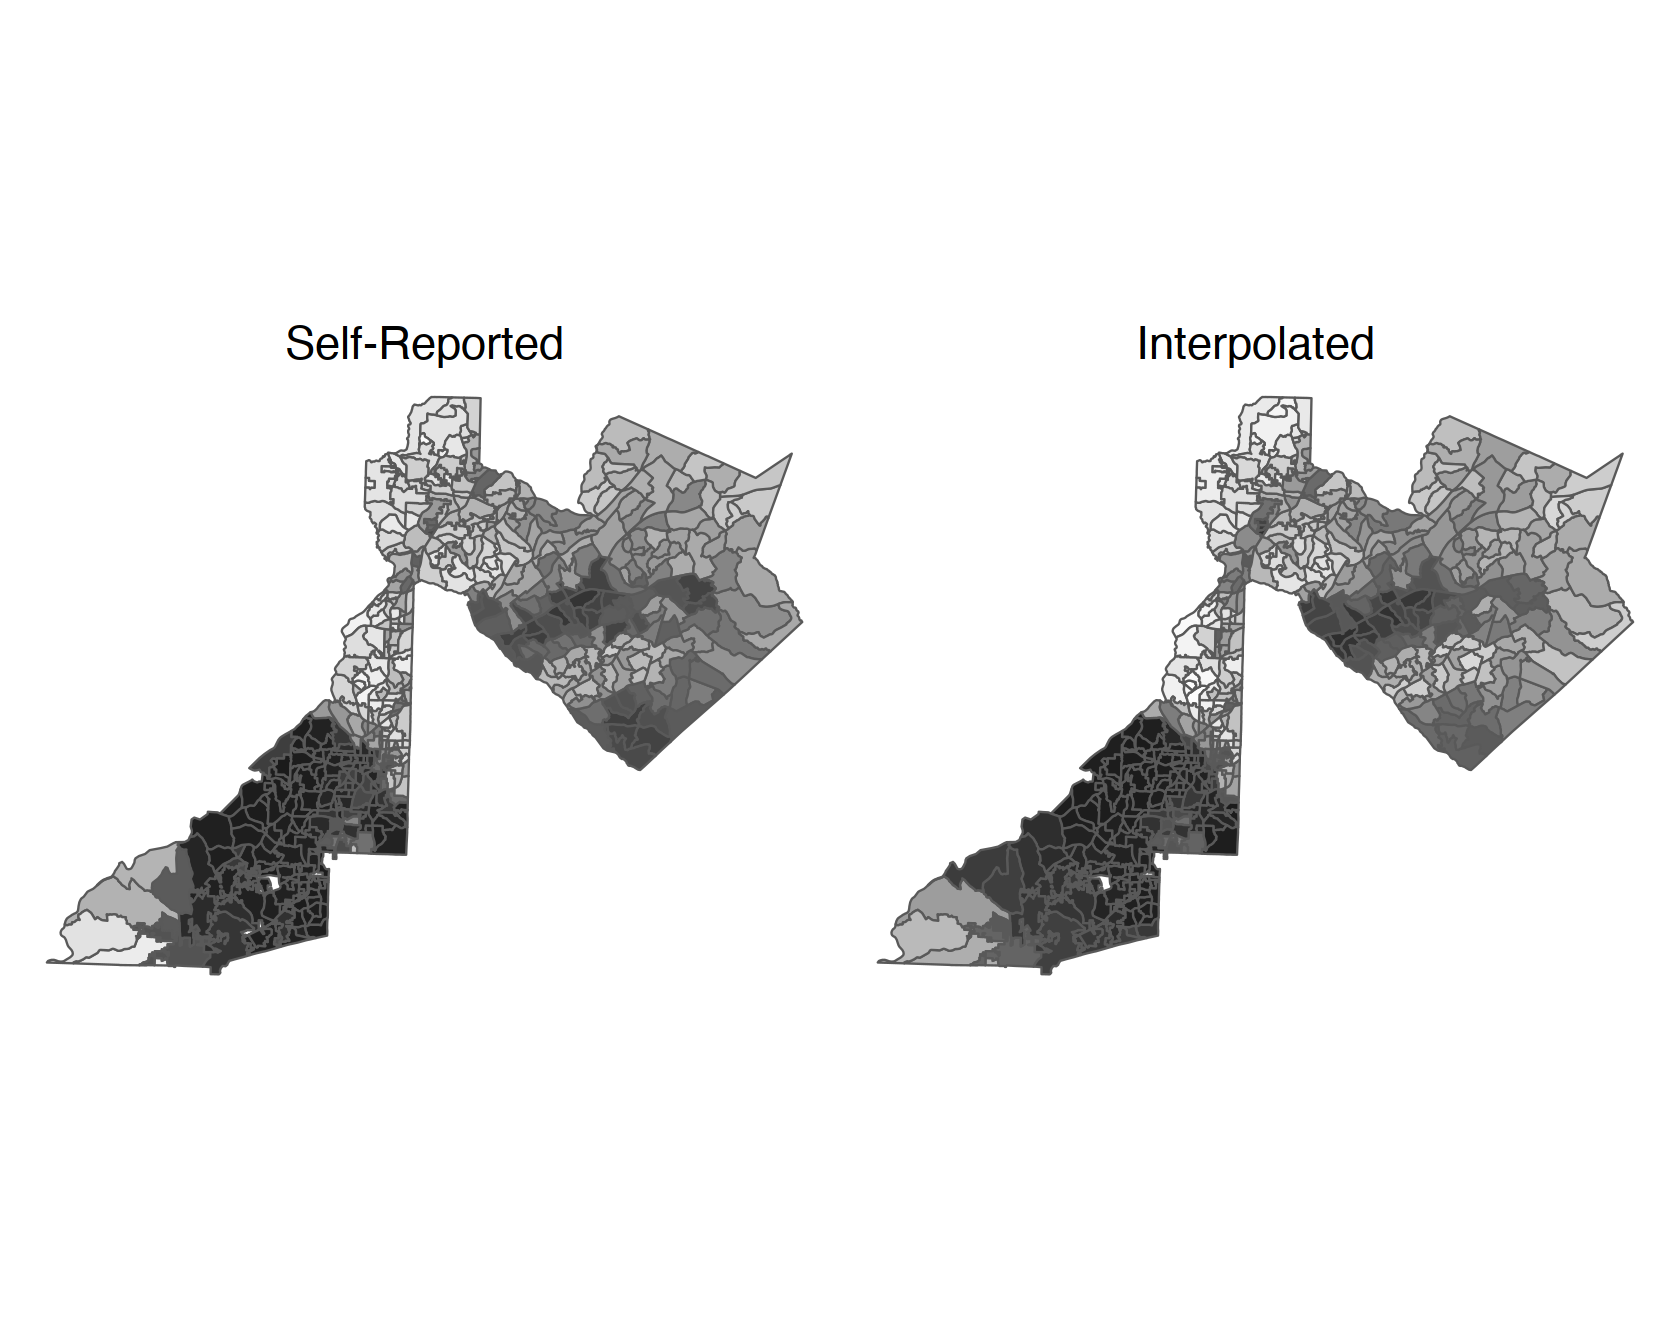

In [35]:
p1 <- ggplot(sf_precincts) +
    geom_sf(aes(fill = whi_true)) +
    scale_fill_gradient2(low = "black", mid = "grey10", high = "white") +
    plot_theme +
    ggtitle("Self-Reported") +
    theme(legend.position = "None",
          axis.text = element_blank())

p2 <- ggplot(sf_precincts) +
    geom_sf(aes(fill = whi_2010_vap_prop)) +
    scale_fill_gradient2(low = "black", mid = "grey10", high = "white") +
    plot_theme +
    ggtitle("Interpolated") +
    theme(legend.position = "None",
          axis.text = element_blank())

p1 + p2